# Introduction

# Libraries and Modules

In [823]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_colwidth', -1)
import numpy as np
import pandas_profiling
import itertools

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("dark")
sns.set_context("paper", font_scale=1.5)
sns.set_palette("GnBu_d")

import os, shutil

from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures, MultiLabelBinarizer
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegressionCV, LogisticRegression
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix, cohen_kappa_score, accuracy_score
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz
from sklearn.metrics import mean_squared_error
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier

from mord import OrdinalRidge
from lightgbm import LGBMClassifier

from IPython.display import Image
import pydotplus

from xgboost import XGBClassifier

In [705]:
import preprocess as pre
import functions as func
import image_classification as im
%reload_ext autoreload
%autoreload 2

# Data

## Data Fields

* Type - Type of animal (1 = Dog, 2 = Cat)
* Name - Name of pet (Empty if not named)
* Age - Age of pet when listed, in months
* Breed1 - Primary breed of pet (Refer to breed_labels.csv)
* Breed2 - Secondary breed of pet, if pet is of mixed breed (Refer to breed_labels.csv
* Gender - Gender of pet (1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)
* Color1 - Color 1 of pet (Refer to color_labels.csv)
* Color2 - Color 2 of pet (Refer to color_labels.csv)
* Color3 - Color 3 of pet (Refer to color_labels.csv)
* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
* Quantity - Number of pets represented in profile
* Fee - Adoption fee (0 = Free)
* State - State location in Malaysia (Refer to state_labels.csv)
* RescuerID - Unique hash ID of rescuer
* VideoAmt - Total uploaded videos for this pet
* Description - Profile write-up for this pet. The primary language used is English, with some in Malay or Chinese.
* PetID - Unique hash ID of pet profile
* PhotoAmt - Total uploaded photos for this pet
* AdoptionSpeed - Categorical speed of adoption:
    - 0 - Pet was adopted on the same day as it was listed.
    - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
    - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
    - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
    - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [706]:
!pwd

/Users/valmadrid/DataScienceBootcamp/Projects/Final Project/Predicting-PetFinder-Adoption-Rate


In [707]:
df = pd.read_csv("dataset/petfinder-adoption-prediction/train/train.csv")
df.columns = df.columns.map(lambda x: x.lower())
df.head(2)

type         name  age  breed1  breed2  gender  color1  color2  color3  \
0  2     Nibble       3    299     0       1       1       7       0        
1  2     No Name Yet  1    265     0       1       1       2       0        

   maturitysize  furlength  vaccinated  dewormed  sterilized  health  \
0  1             1          2           2         2           1        
1  2             2          3           3         3           1        

   quantity  fee  state                         rescuerid  videoamt  \
0  1         100  41326  8480853f516546f6cf33aa88cd76c379  0          
1  1         0    41401  3082c7125d8fb66f7dd4bff4192c8b14  0          

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

       petid  photoamt  adoptionspeed  
0  86e1089a3  1.0       2              
1  6296e909a  2.0       0

## Exploratory Data Analysis

In [708]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14993 entries, 0 to 14992
Data columns (total 24 columns):
type             14993 non-null int64
name             13736 non-null object
age              14993 non-null int64
breed1           14993 non-null int64
breed2           14993 non-null int64
gender           14993 non-null int64
color1           14993 non-null int64
color2           14993 non-null int64
color3           14993 non-null int64
maturitysize     14993 non-null int64
furlength        14993 non-null int64
vaccinated       14993 non-null int64
dewormed         14993 non-null int64
sterilized       14993 non-null int64
health           14993 non-null int64
quantity         14993 non-null int64
fee              14993 non-null int64
state            14993 non-null int64
rescuerid        14993 non-null object
videoamt         14993 non-null int64
description      14981 non-null object
petid            14993 non-null object
photoamt         14993 non-null float64
adoptionspe

In [709]:
breeds = pd.read_csv("dataset/petfinder-adoption-prediction/breed_labels.csv")
colors = pd.read_csv("dataset/petfinder-adoption-prediction/color_labels.csv")
states = pd.read_csv("dataset/petfinder-adoption-prediction/state_labels.csv")

df = pre.get_breed(df, breeds, "breed1")
df = pre.get_breed(df, breeds, "breed2")
df = pre.get_color(df, colors, "color1")
df = pre.get_color(df, colors, "color2")
df = pre.get_color(df, colors, "color3")
df = pre.get_state(df, states, "state")
df.head(2)

type         name  age  breed1  breed2  gender  color1  color2  color3  \
0  2     Nibble       3    299     0       1       1       7       0        
1  2     No Name Yet  1    265     0       1       1       2       0        

   maturitysize  furlength  vaccinated  dewormed  sterilized  health  \
0  1             1          2           2         2           1        
1  2             2          3           3         3           1        

   quantity  fee  state                         rescuerid  videoamt  \
0  1         100  41326  8480853f516546f6cf33aa88cd76c379  0          
1  1         0    41401  3082c7125d8fb66f7dd4bff4192c8b14  0          

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

       petid  photoamt  adoptionspeed           breed1_desc breed2_desc  \
0  86e1089a3  1.0       2              tabby                 NaN          
1  6296e909a  2.0       0              domestic_medium_hair  NaN          

  color1_desc color2_desc color3_desc    state_desc  
0  black       white       NaN         selangor      
1  black       brown       NaN         kuala_lumpur

In [710]:
#Rename the columns (add "_")
df.rename(mapper={
    "maturitysize": "maturity_size",
    "furlength": "fur_length",
    "rescuerid": "rescuer_id",
    "videoamt": "video_count",
    "photoamt": "photo_count",
    "petid": "pet_id",
    "adoptionspeed": "adoption_speed"
},
            axis=1,
            inplace=True)

In [711]:
#Add image filename and sentiment analysis of the pet description

images_folder_path = "dataset/petfinder-adoption-prediction/train_images/"
df = pre.get_image_filename(df, images_folder_path)

sentiment_folder_path = "dataset/petfinder-adoption-prediction/train_sentiment/"
df = pre.get_sentiment_analysis(df, sentiment_folder_path)

df.head(2)

There are a total of  58311  pet images.
341 pets have no images.


type         name  age  breed1  breed2  gender  color1  color2  color3  \
0  2     Nibble       3    299     0       1       1       7       0        
1  2     No Name Yet  1    265     0       1       1       2       0        

   maturity_size  fur_length  vaccinated  dewormed  sterilized  health  \
0  1              1           2           2         2           1        
1  2              2           3           3         3           1        

   quantity  fee  state                        rescuer_id  video_count  \
0  1         100  41326  8480853f516546f6cf33aa88cd76c379  0             
1  1         0    41401  3082c7125d8fb66f7dd4bff4192c8b14  0             

                                                                                                                                                                                                                                                                                                                                                               description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.   
1  I just found it alone yesterday near my apartment. It was shaking so I had to bring it home to provide temporary care.                                                                                                                                                                                                                                                    

      pet_id  photo_count  adoption_speed           breed1_desc breed2_desc  \
0  86e1089a3  1.0          2               tabby                 NaN          
1  6296e909a  2.0          0               domestic_medium_hair  NaN          

  color1_desc color2_desc color3_desc    state_desc         filename  \
0  black       white       NaN         selangor      86e1089a3-1.jpg   
1  black       brown       NaN         kuala_lumpur  6296e909a-1.jpg   

   desc_score  desc_magnitude  
0  0.3         2.4             
1 -0.2         0.7

In [712]:
#Rearrange the column headers
df = df[[
    "adoption_speed", "pet_id", "type", "name", "age", "breed1", "breed1_desc",
    "breed2", "breed2_desc", "gender", "color1", "color1_desc", "color2",
    "color2_desc", "color3", "color3_desc", "maturity_size", "fur_length",
    "vaccinated", "dewormed", "sterilized", "health", "quantity", "fee",
    "state", "state_desc", "rescuer_id", "video_count", "photo_count", "filename",
    "description", "desc_score", "desc_magnitude"
]]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14993 entries, 0 to 14992
Data columns (total 33 columns):
adoption_speed    14993 non-null int64
pet_id            14993 non-null object
type              14993 non-null int64
name              13736 non-null object
age               14993 non-null int64
breed1            14993 non-null int64
breed1_desc       14988 non-null object
breed2            14993 non-null int64
breed2_desc       4231 non-null object
gender            14993 non-null int64
color1            14993 non-null int64
color1_desc       14993 non-null object
color2            14993 non-null int64
color2_desc       10522 non-null object
color3            14993 non-null int64
color3_desc       4389 non-null object
maturity_size     14993 non-null int64
fur_length        14993 non-null int64
vaccinated        14993 non-null int64
dewormed          14993 non-null int64
sterilized        14993 non-null int64
health            14993 non-null int64
quantity          14993 non-

In [713]:
# Save this version
df.to_csv("pets.csv", index=False)

In [714]:
#Run a profile report
petfinder_report = df.profile_report(
    title="Petfinder.my Detailed Profile Report",
    correlation_threshold_pearson=.9,
    sort="None")
petfinder_report.to_file(output_file="pets.html")
petfinder_report

### Adoption Speed Rate

    - 0 - Pet was adopted on the same day as it was listed.
    - 1 - Pet was adopted between 1 and 7 days (1st week) after being listed.
    - 2 - Pet was adopted between 8 and 30 days (1st month) after being listed.
    - 3 - Pet was adopted between 31 and 90 days (2nd & 3rd month) after being listed.
    - 4 - No adoption after 100 days of being listed. (There are no pets in this dataset that waited between 90 and 100 days).

In [383]:
pets = pd.read_csv("pets.csv")
pets.shape

(14993, 34)

In [253]:
display(pd.DataFrame((pets.adoption_speed.value_counts(normalize=True)*100)).head(20))

adoption_speed
4  27.993063     
2  26.925899     
3  21.736811     
1  20.609618     
0  2.734609

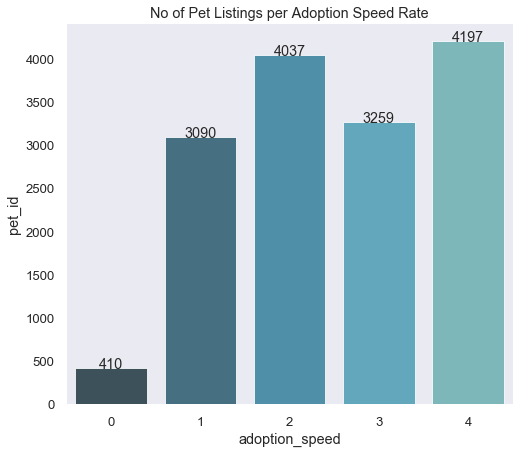

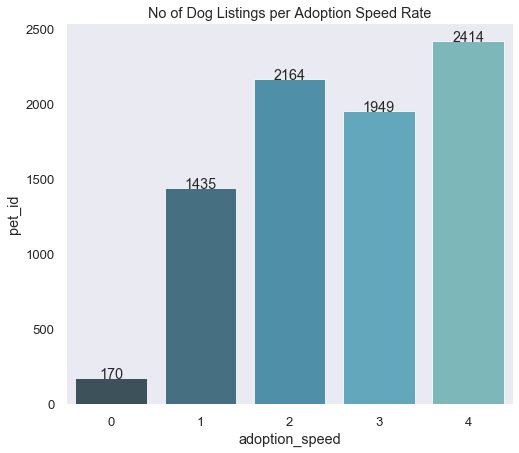

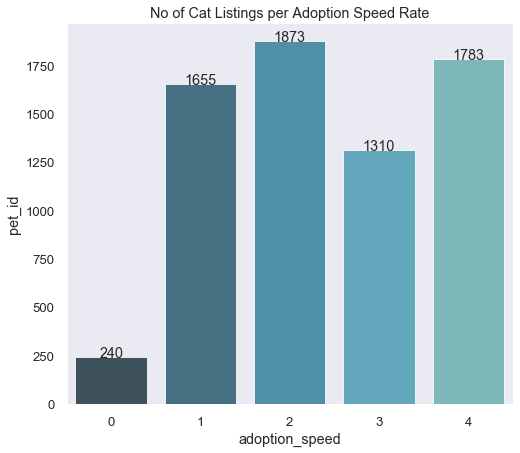

In [144]:
df_plot = pets.groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Pet Listings per Adoption Speed Rate")

df_plot = pets.query("type ==1").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Dog Listings per Adoption Speed Rate")

df_plot = pets.query("type ==2").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Cat Listings per Adoption Speed Rate")

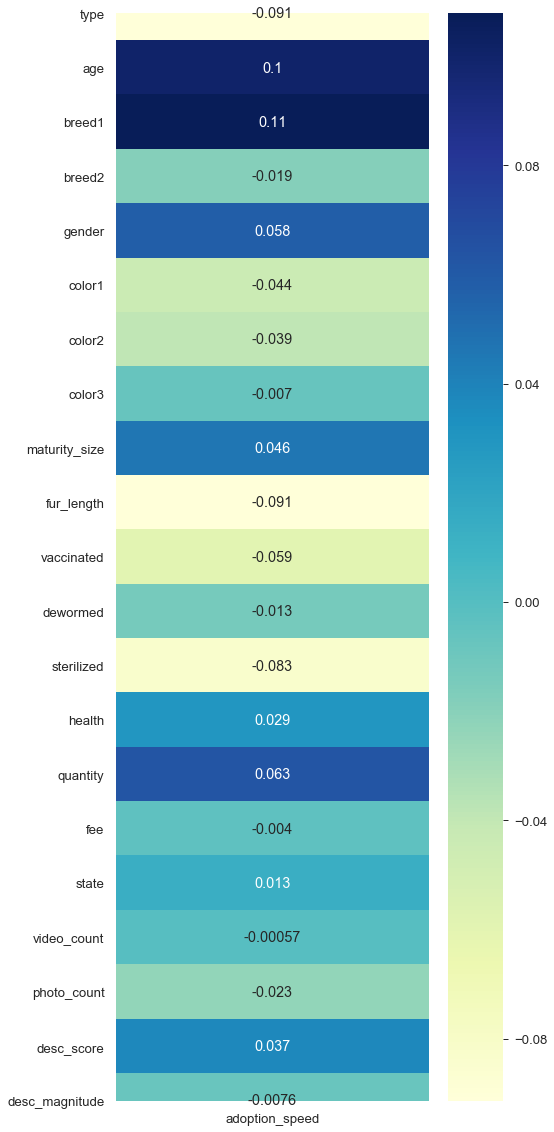

In [411]:
plt.figure(figsize=(7, 20))
sns.heatmap(data = pets.corr()[["adoption_speed"]].iloc[1:,:], annot=True, cmap="YlGnBu");

The dataset is imbalanced mainly because of class 0 (3%). This class means the pets were adopted the same day they were listed. Upon checking with Petfinder.my....XXXXXX

Also the purpose of this project is to .....

Based on the above, I will move class 0 to 1.  Class 1 latter means the pets were adopted within the week of being listed.

### Type

Type of animal (1 = Dog, 2 = Cat)

In [384]:
display(pd.DataFrame((pets.age.value_counts(normalize=True)*100)).head(20))

type
1  54.238645
2  45.761355

### Name

### Age

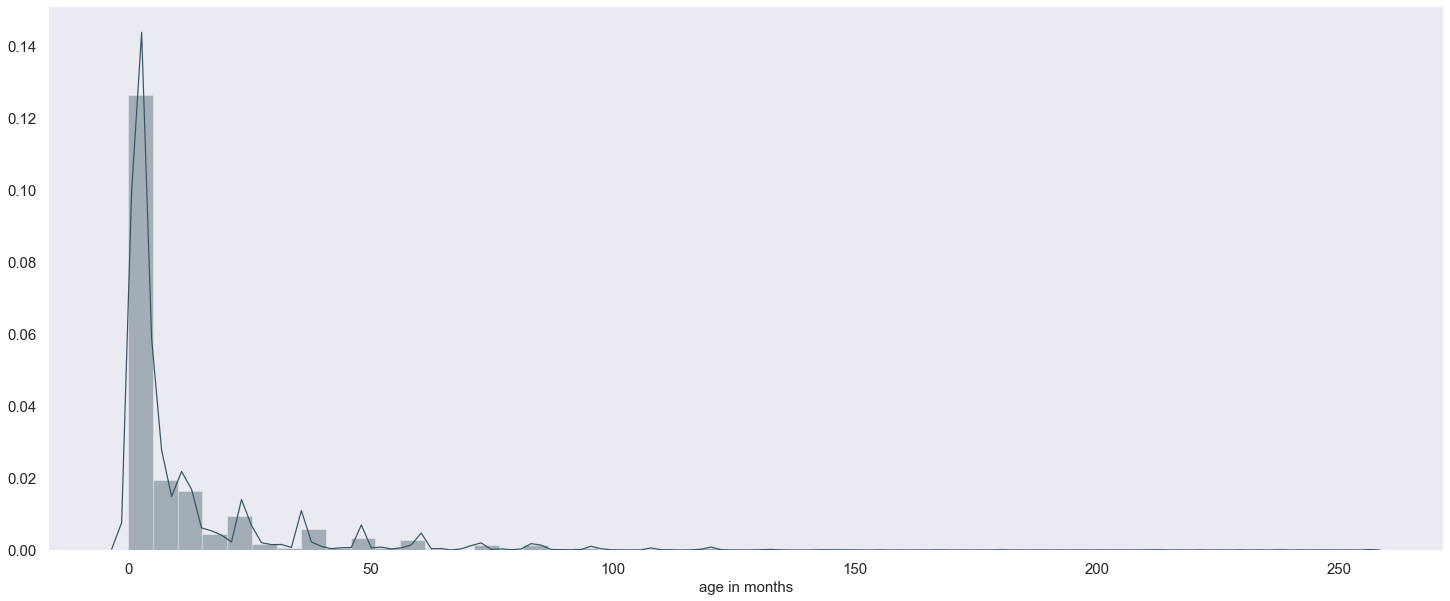

In [145]:
pre.plot_hist(pets["age"], "age in months", (25, 10))

In [252]:
# Around 52% of the pets is between 1-3 months old.

display(pd.DataFrame((pets.age.value_counts(normalize=True)*100)).head(20))

age
2   23.364237
1   15.367171
3   13.112786
4   7.396785 
12  6.449677 
24  4.342026 
5   3.968519 
6   3.721737 
36  2.781298 
8   2.060962 
7   1.874208 
48  1.607417 
60  1.327286 
9   1.227239 
0   1.193890 
18  1.100514 
10  1.080504 
72  0.693657 
84  0.680317 
11  0.626959

In [186]:
#There are 392 pets that are more than 5 years old.
#First 2 lines are duplicates. I will remove one entry at the Pre-processing section.

pets.query("age > ")[["adoption_speed","pet_id", "age", "description"]].sort_values("age", ascending = False)

adoption_speed     pet_id  age  \
5160   4               5971c2462  255   
11172  4               50682d0f1  255   
13398  4               e01f077a7  238   
3998   3               53923463d  212   
11087  3               e77f9e778  212   
...   ..                     ...  ...   
5634   1               a3f6438ea  62    
5388   3               b1f1a42bf  62    
11254  4               3d6f14681  61    
12440  4               28c4588e5  61    
5034   3               2b6fe231b  61    

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     description  
5160   very suitable to be a guard. easy handle. :) cute and fierce to strangers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
11172  very suitable to be a guard. easy handle. :) cute and fierce to strangers                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  
13398  Enzo was adopted from a pet store, and raised well. Mostly stayed indoors. Feed twice a day. Easy to bath. Clean & healthy. Know some tricks. Friendly and adorable.                      

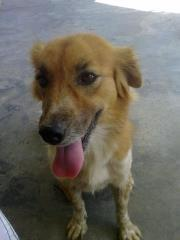

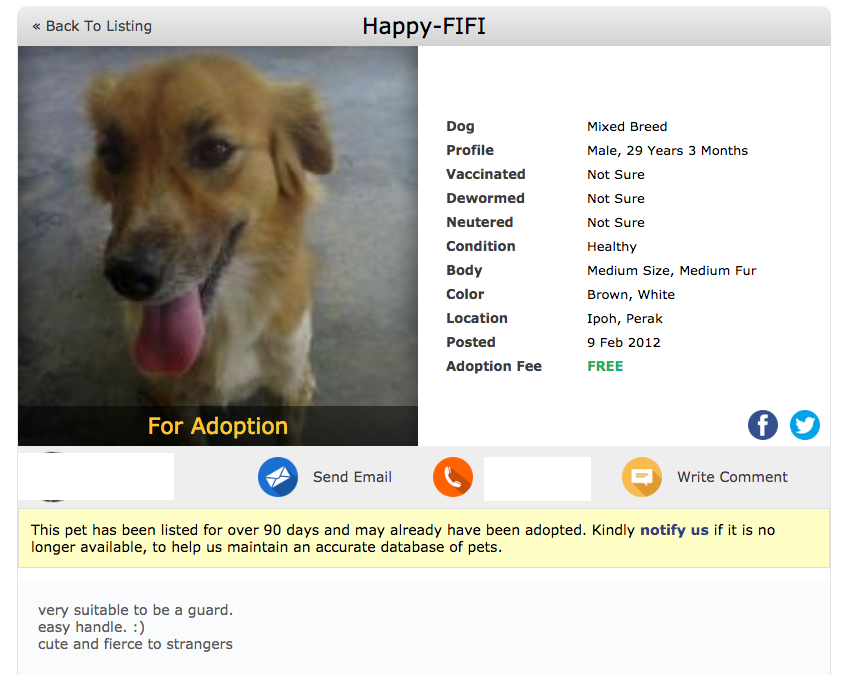

In [194]:
#I have checked the website to know why pet_id 5971c2462 is 255 months old.
#Fifi was listed on Petfinder.my in Feb 2012.

images_folder_path = "dataset/petfinder-adoption-prediction/train_images/"
pre.get_pet_image(images_folder_path, "5971c2462")
pre.get_image("dataset/", "fifi.png")

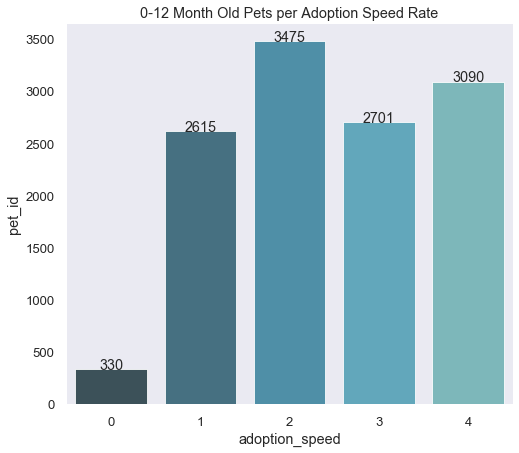

2          4          3          1         0
adoption_speed  28.457948  25.305053  22.119401  21.415118  2.702481

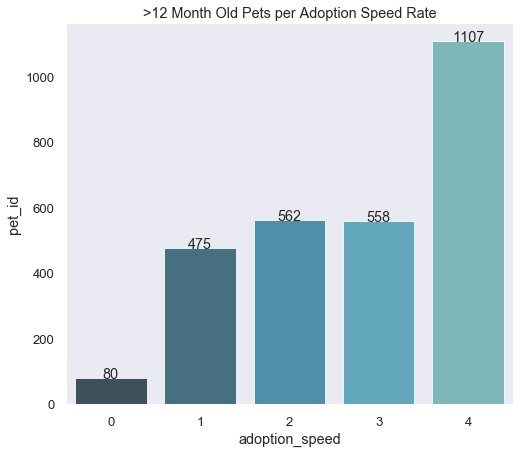

4          2          3          1         0
adoption_speed  39.791517  20.201294  20.057513  17.074047  2.875629

In [248]:
df_plot = pets.query("age <= 12").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "0-12 Month Old Pets per Adoption Speed Rate")
display(pd.DataFrame((pets.query("age <= 12").adoption_speed.value_counts(normalize=True)*100)).T)

df_plot = pets.query("age > 12").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", ">12 Month Old Pets per Adoption Speed Rate")
display(pd.DataFrame((pets.query("age > 12").adoption_speed.value_counts(normalize=True)*100)).T)

In [179]:
# df_plot = pets.groupby("age").count()[["pet_id"]].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months)]", figsize = [30, 10])

# df_plot = pets.query("adoption_speed <= 1").groupby(["adoption_speed","age"]).count().iloc[:,:1].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months) [Adoption Speed <=1]", figsize = [25, 10])

# df_plot = pets.query("adoption_speed == 2").groupby(["adoption_speed","age"]).count().iloc[:,:1].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months) [Adoption Speed = 2]", figsize = [25, 10])

# df_plot = pets.query("adoption_speed == 3").groupby(["adoption_speed","age"]).count().iloc[:,:1].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months) [Adoption Speed = 3]", figsize = [25, 10])

# df_plot = pets.query("adoption_speed == 4").groupby(["adoption_speed","age"]).count().iloc[:,:1].reset_index()
# pre.plot_bar(df_plot, "age", "pet_id", "No of Pet Listing per Age (in months) [Adoption Speed = 4]", figsize = [25, 10])

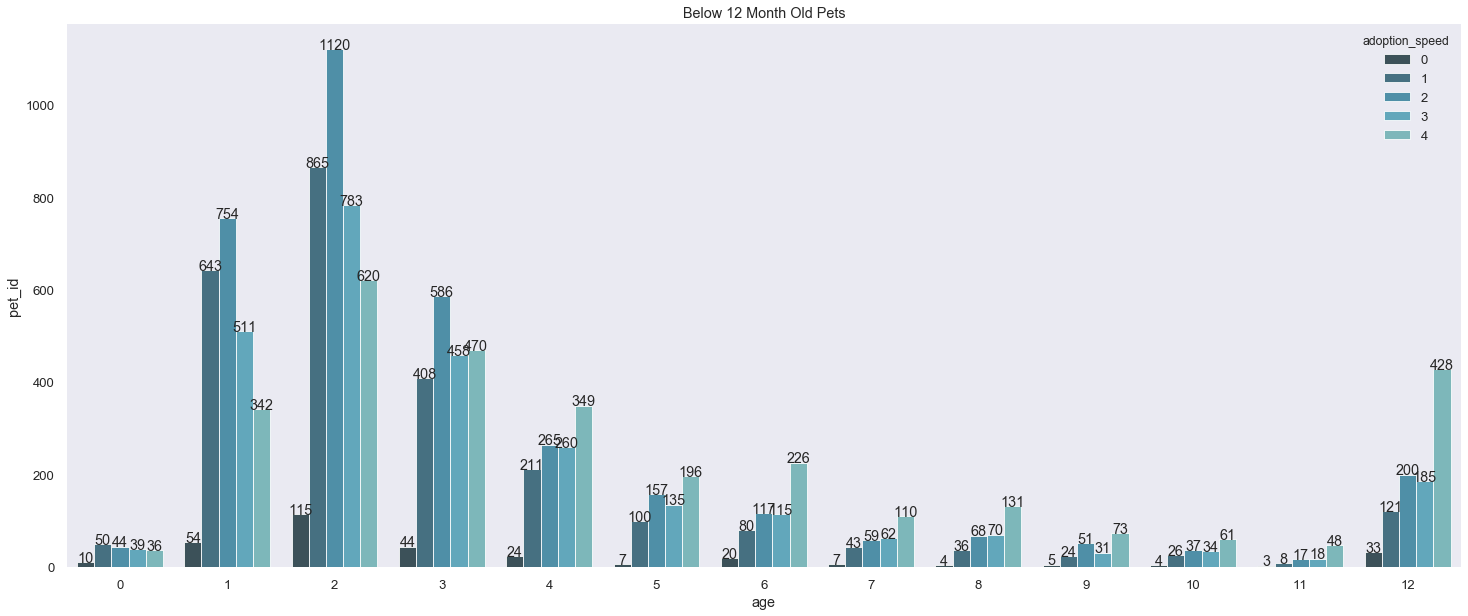

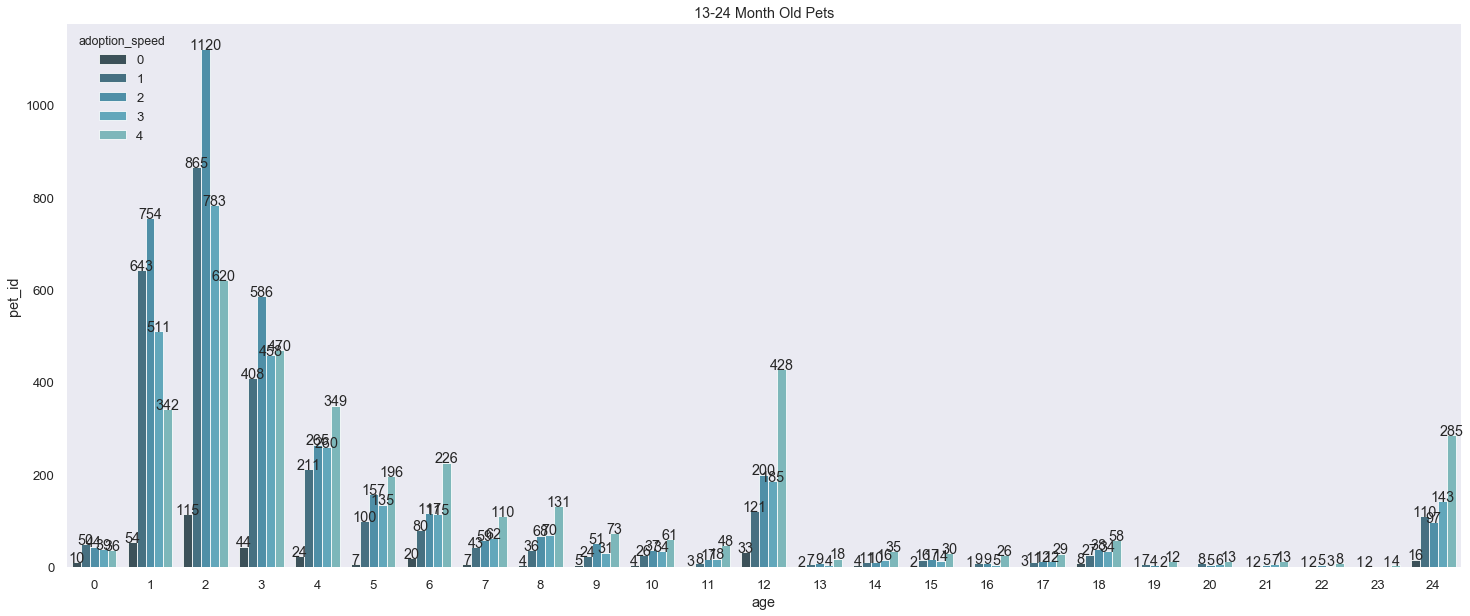

In [178]:
df_plot = pets.groupby(["age", "adoption_speed"]).count().iloc[:,:1].reset_index()
pre.plot_bar_hue(df_plot.query("age <= 12"), "age", "pet_id", "adoption_speed", "Below 12 Month Old Pets", figsize = (25, 10))
pre.plot_bar_hue(df_plot.query("age <= 24"), "age", "pet_id", "adoption_speed", "13-24 Month Old Pets", figsize = (25, 10))

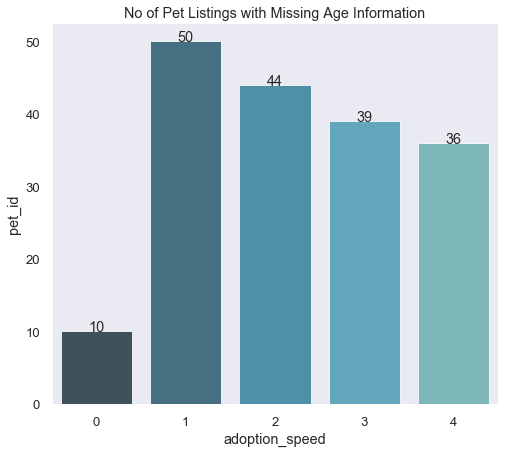

In [153]:
df_plot = pets.query("age == 0").groupby("adoption_speed").count().reset_index()
pre.plot_bar(df_plot, "adoption_speed", "pet_id", "No of Pet Listings with Missing Age Information")

* Most of the pets are 1-3 months old.
* Multiples of 12 were used as placeholders. 
* Only 2782 (19%) are more than 12 months old. Some of them are even more than 20 years old. 
* Some of them have been listed for a while.  
* 0-12 month old pets are adopted faster than >12 month.
* Age has a very low correlation with adoption speed.

I will convert the age into categorical feature: 0-1 year old and more than 1 year old. 

I see no issue with age = 0 at adoption speed of 0-2 as this means the pets were adopted before they reached the age of 1 month. 

Adoption speed rates at 3 & 4 mean that the pets were already been listed for more than a month.  I will be removing these listings with age = 0 (0.5% of the dataset) as these seem to be errors.

In [184]:
len(pets.query("age <= 12"))/len(pets)

0.814446741812846

### Breed

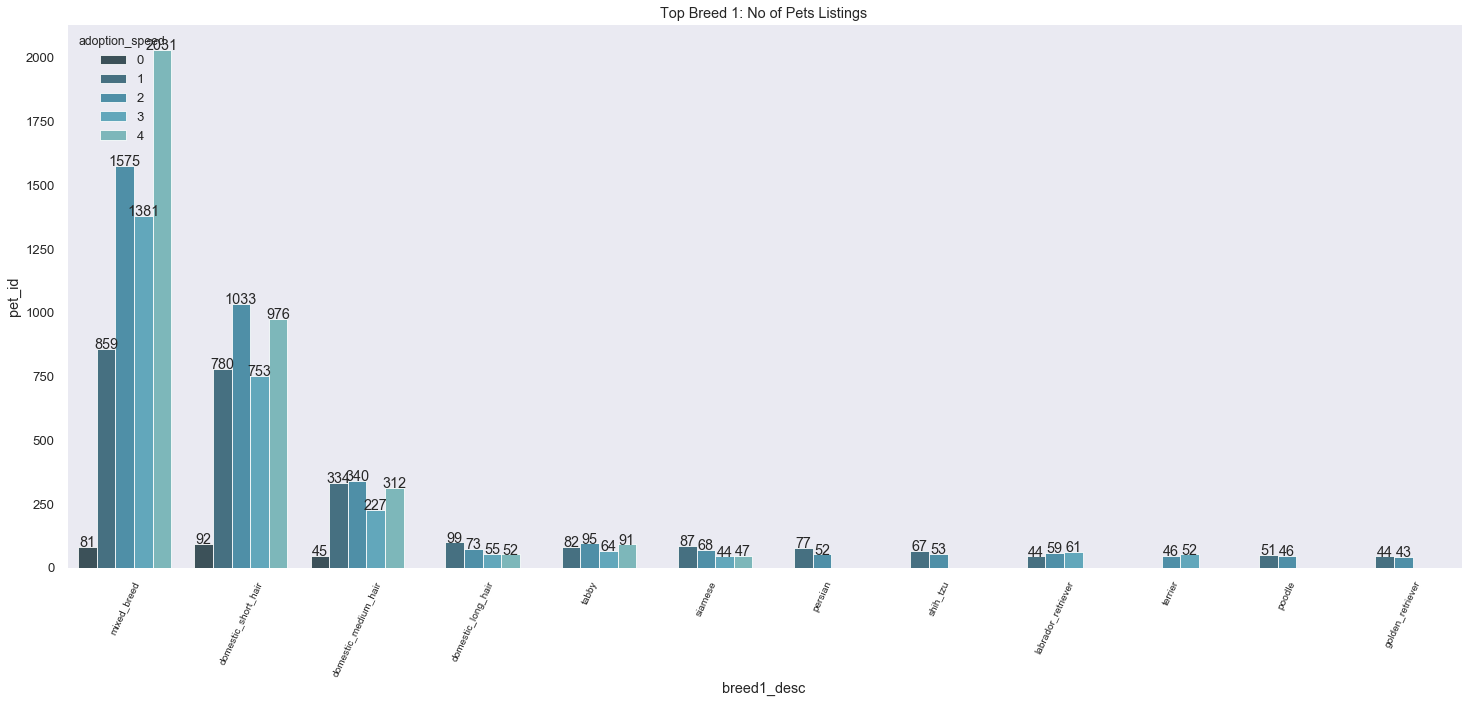

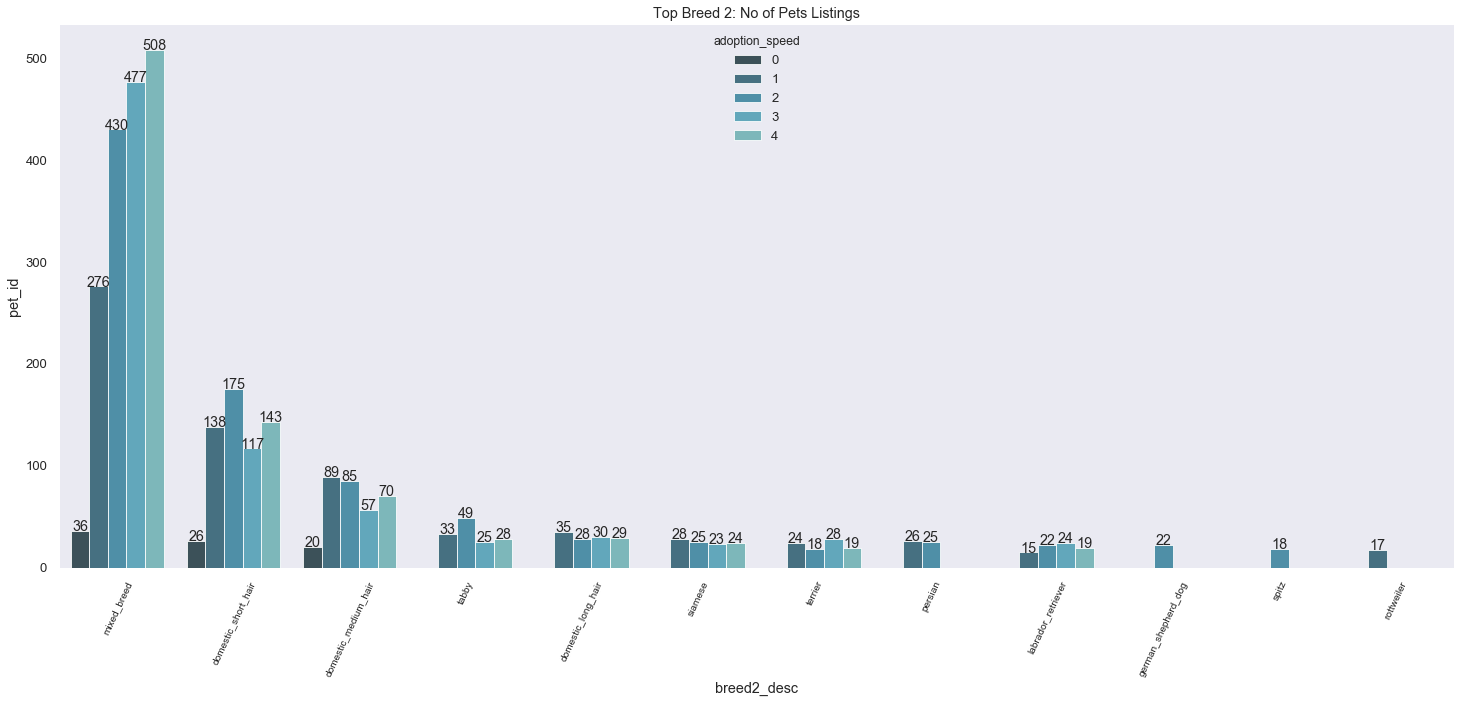

In [225]:
df_plot = pets[["breed1_desc", "adoption_speed",
                "pet_id"]].groupby(["breed1_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).iloc[:40, ].reset_index()

pre.plot_bar_hue(df_plot, "breed1_desc", "pet_id", "adoption_speed", 
             "Top Breed 1: No of Pets Listings", figsize = (25,10),rotate = True)

df_plot = pets[["breed2_desc", "adoption_speed",
                "pet_id"]].groupby(["breed2_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).iloc[:40, ].reset_index()

pre.plot_bar_hue(df_plot, "breed2_desc", "pet_id", "adoption_speed", 
             "Top Breed 2: No of Pets Listings", figsize = (25,10),rotate = True)


In [273]:
display(pd.DataFrame((pets.breed1_desc.value_counts(normalize=True)*100)).head(10))
display(pd.DataFrame((pets.breed2_desc.value_counts(normalize=True)*100).head(10)))

breed1_desc
mixed_breed           39.544969  
domestic_short_hair   24.246064  
domestic_medium_hair  8.393381   
tabby                 2.281825   
domestic_long_hair    1.974913   
siamese               1.761409   
persian               1.474513   
labrador_retriever    1.367761   
shih_tzu              1.267681   
poodle                1.114225

breed2_desc
mixed_breed           40.817774  
domestic_short_hair   14.157410  
domestic_medium_hair  7.586859   
tabby                 3.261640   
domestic_long_hair    2.954384   
siamese               2.481683   
terrier               2.150792   
labrador_retriever    2.032616   
persian               1.843536   
german_shepherd_dog   1.299929

In [270]:
# Most of the mixed bred pets are adopted within one month.
# Percentage for each adoption speed rate shown below. First table is for breed1, second is for breed2.

display(pd.DataFrame((pets.query("breed1 == 307").adoption_speed.value_counts(normalize=True)*100)))
display(pd.DataFrame((pets.query("breed2 == 307").adoption_speed.value_counts(normalize=True)*100)))

adoption_speed
4  34.266914     
2  26.573309     
3  23.300152     
1  14.492998     
0  1.366627

adoption_speed
4  29.415171     
3  27.620151     
2  24.898668     
1  15.981471     
0  2.084540

In [269]:
# Most of the domestic pets are adopted within one month as well. 
# Percentage for each adoption speed rate shown below. First table is for breed1, second is for breed2.

q1 = """SELECT * FROM pets WHERE breed1_desc LIKE "%Domestic%";"""
df1 = pysqldf(q1)

q2 = """SELECT * FROM pets WHERE breed2_desc LIKE "%Domestic%";"""
df2 = pysqldf(q2)

display(pd.DataFrame((df1.adoption_speed.value_counts(normalize=True)*100)))
display(pd.DataFrame((df2.adoption_speed.value_counts(normalize=True)*100)))

adoption_speed
2  27.872012     
4  25.828836     
1  23.380879     
3  19.949884     
0  2.968389

adoption_speed
2  27.559809     
1  25.071770     
4  23.157895     
3  19.521531     
0  4.688995

In [110]:
q = """SELECT breed1_desc, fur_length, count(breed1_desc) as listing_count FROM pets WHERE breed1_desc LIKE "%Domestic%" GROUP by breed1_desc, fur_length ORDER by listing_count DESC;"""
table = pysqldf(q)
table

breed1_desc  fur_length  listing_count
0  domestic_short_hair   1           3181         
1  domestic_medium_hair  2           1162         
2  domestic_short_hair   2           443          
3  domestic_long_hair    3           201          
4  domestic_long_hair    2           86           
5  domestic_medium_hair  1           77           
6  domestic_medium_hair  3           19           
7  domestic_short_hair   3           10           
8  domestic_long_hair    1           9

* Mixed bred and domestic are the most common values.  Both breed types are adopted within one month.
* 40% and 41% of breed 1 and 2 columns, respectively, are mixed bred.
* 35% and 25% of breed 1 and 2 columns, respectively, are domestic.
* The domestic breed types are not consistent with the fur length.  

Upon checking the website, the breed fields are drop downs while the fur lengths are radio buttons.  The fur length would be more accurately selected as compared to the specific type of "Domestic" breed. I will be changing all these to "Domestic" only and assume that the fur length is correct.

Also I will be adding a column that will categorise the listings into Mixed Bred, Pure Bred, Domestic

### Gender

(1 = Male, 2 = Female, 3 = Mixed, if profile represents group of pets)

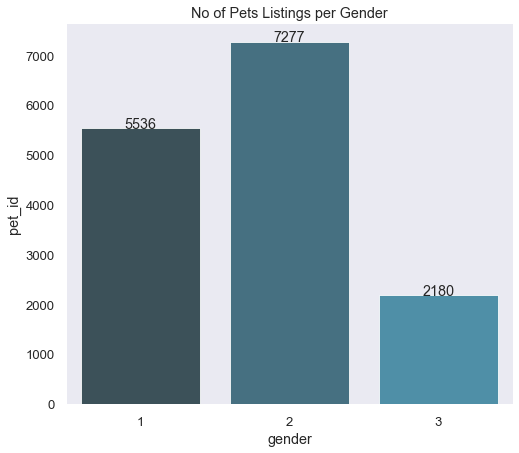

gender
2  48.535983
1  36.923898
3  14.540119

In [290]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender","type", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar(df_plot.groupby("gender").sum().reset_index(), "gender", "pet_id",
             "No of Pets Listings per Gender", rotate = False)

display(pd.DataFrame((pets.gender.value_counts(normalize=True)*100)))

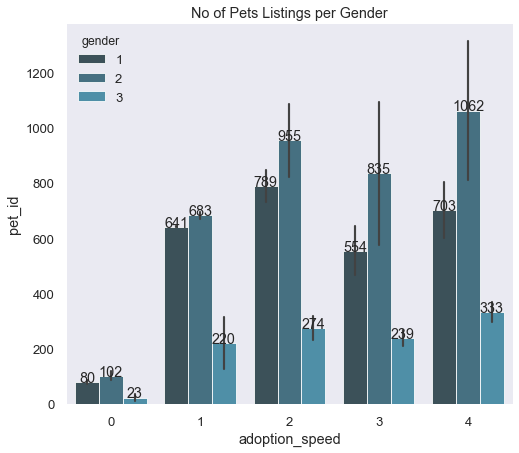

In [283]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender","type", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot,"adoption_speed", "pet_id", "gender", "No of Pets Listings per Gender", rotate = False)

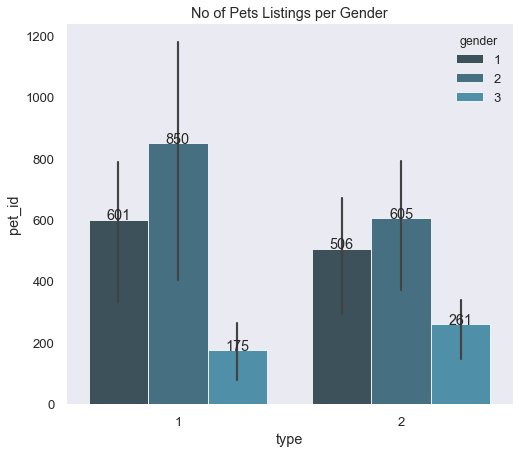

In [284]:
df_plot = pets[["gender","type", "adoption_speed", "pet_id"]].groupby(["gender", "adoption_speed", "type"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot,"type", "pet_id", "gender", "No of Pets Listings per Gender", rotate = False)

### Color

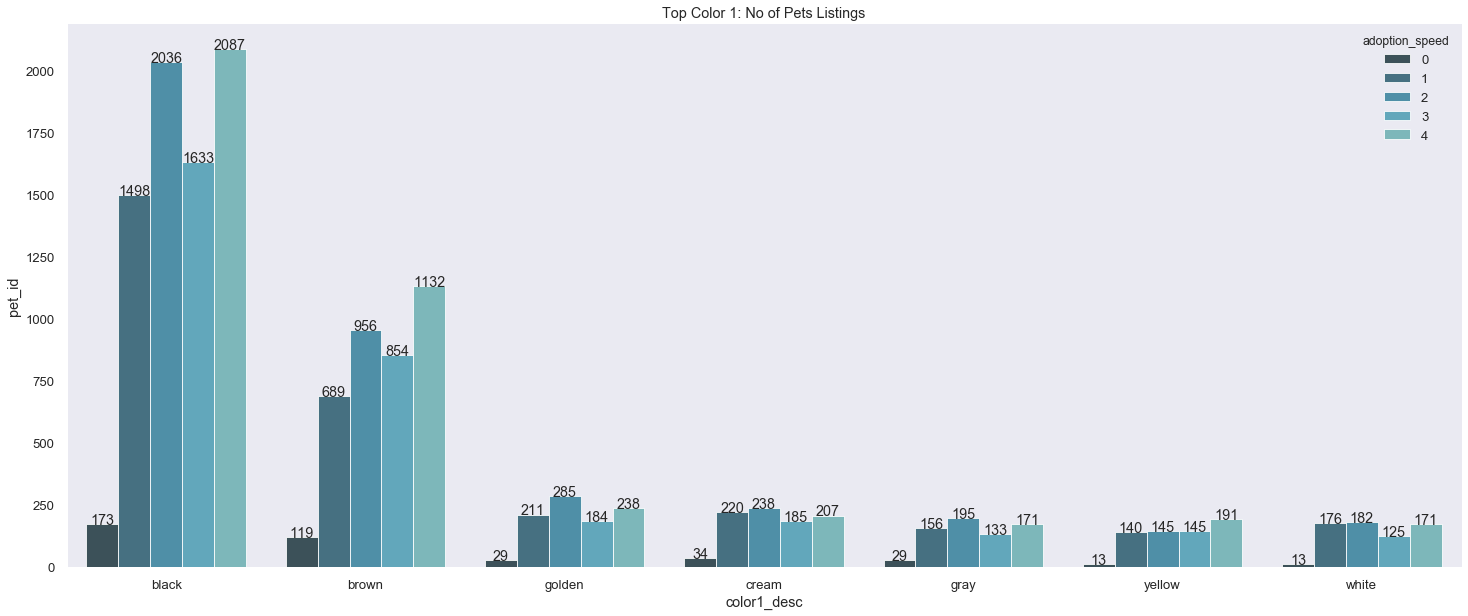

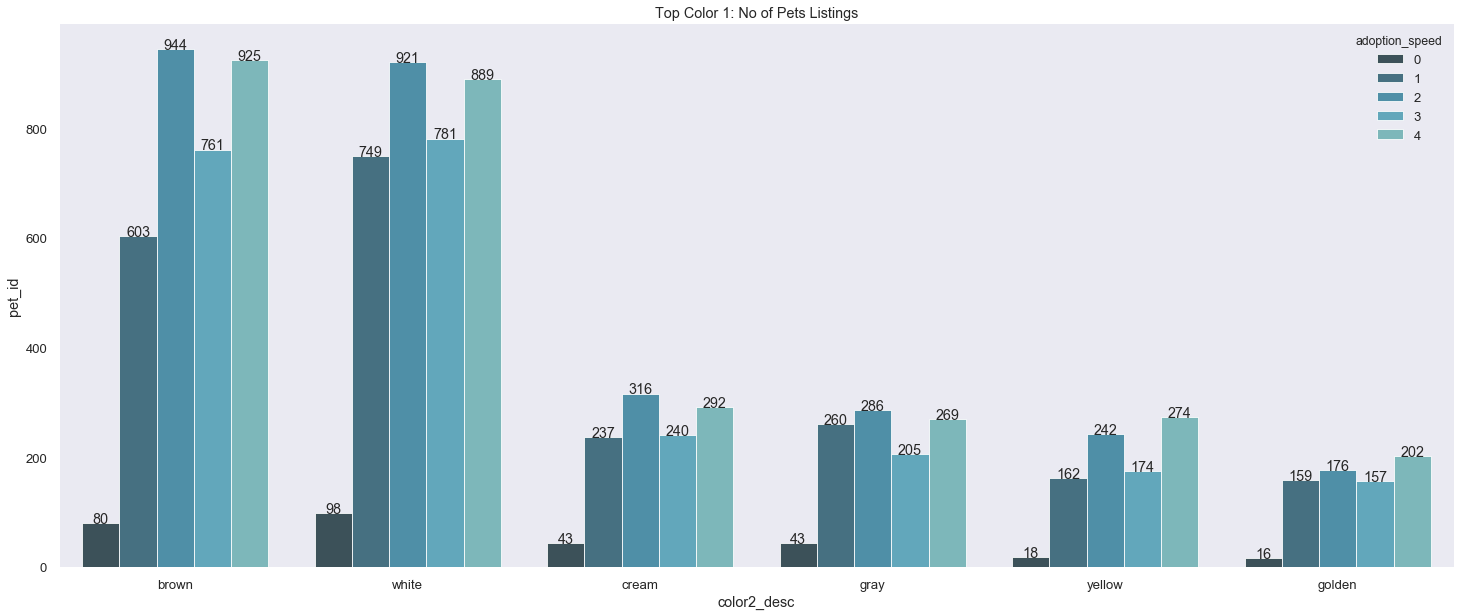

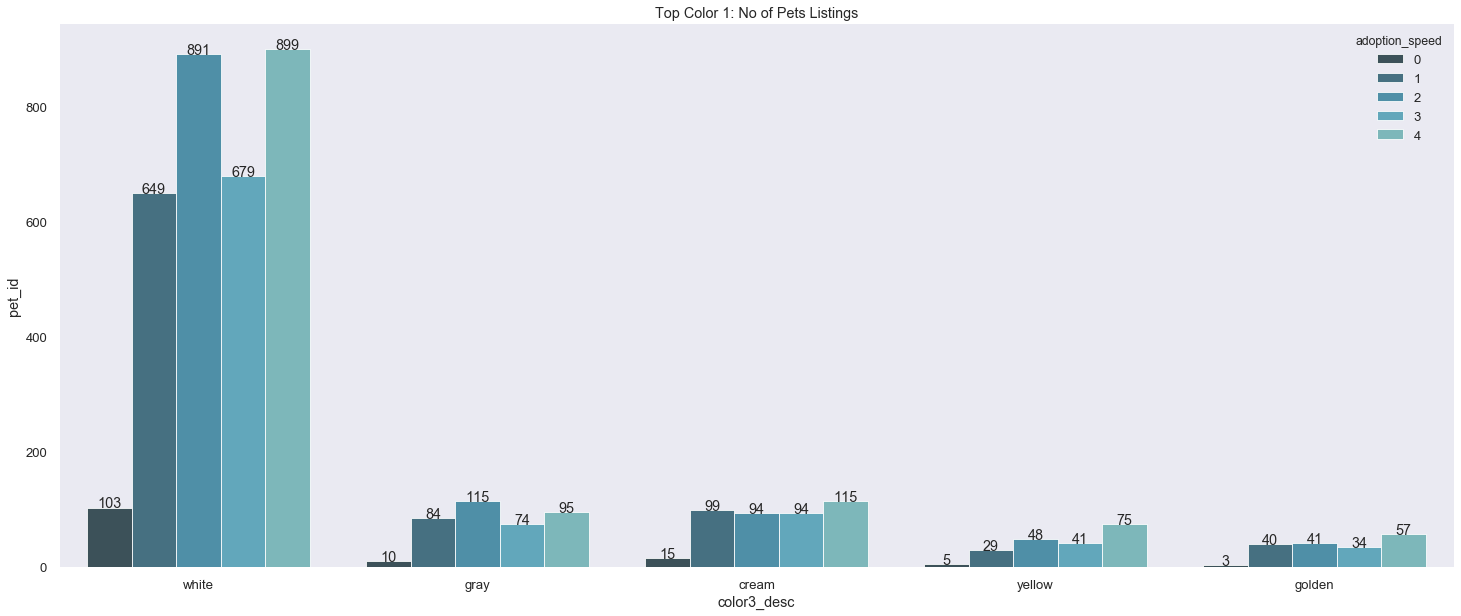

In [314]:
df_plot = pets[["color1_desc", "adoption_speed",
                "pet_id"]].groupby(["color1_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "color1_desc", "pet_id", "adoption_speed", 
             "Top Color 1: No of Pets Listings", figsize = (25,10))

df_plot = pets[["color2_desc", "adoption_speed",
                "pet_id"]].groupby(["color2_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "color2_desc", "pet_id", "adoption_speed", 
             "Top Color 1: No of Pets Listings", figsize = (25,10))

df_plot = pets[["color3_desc", "adoption_speed",
                "pet_id"]].groupby(["color3_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "color3_desc", "pet_id", "adoption_speed", 
             "Top Color 1: No of Pets Listings", figsize = (25,10))

In [340]:
petscopy = pets.copy().fillna("")
petscopy["color_combination"] = pd.Series()

for i in range(len(petscopy)):
    petscopy["color_combination"].iloc[i] = "".join(sorted([petscopy["color1_desc"].iloc[i], petscopy["color2_desc"].iloc[i], petscopy["color3_desc"].iloc[i]]))  

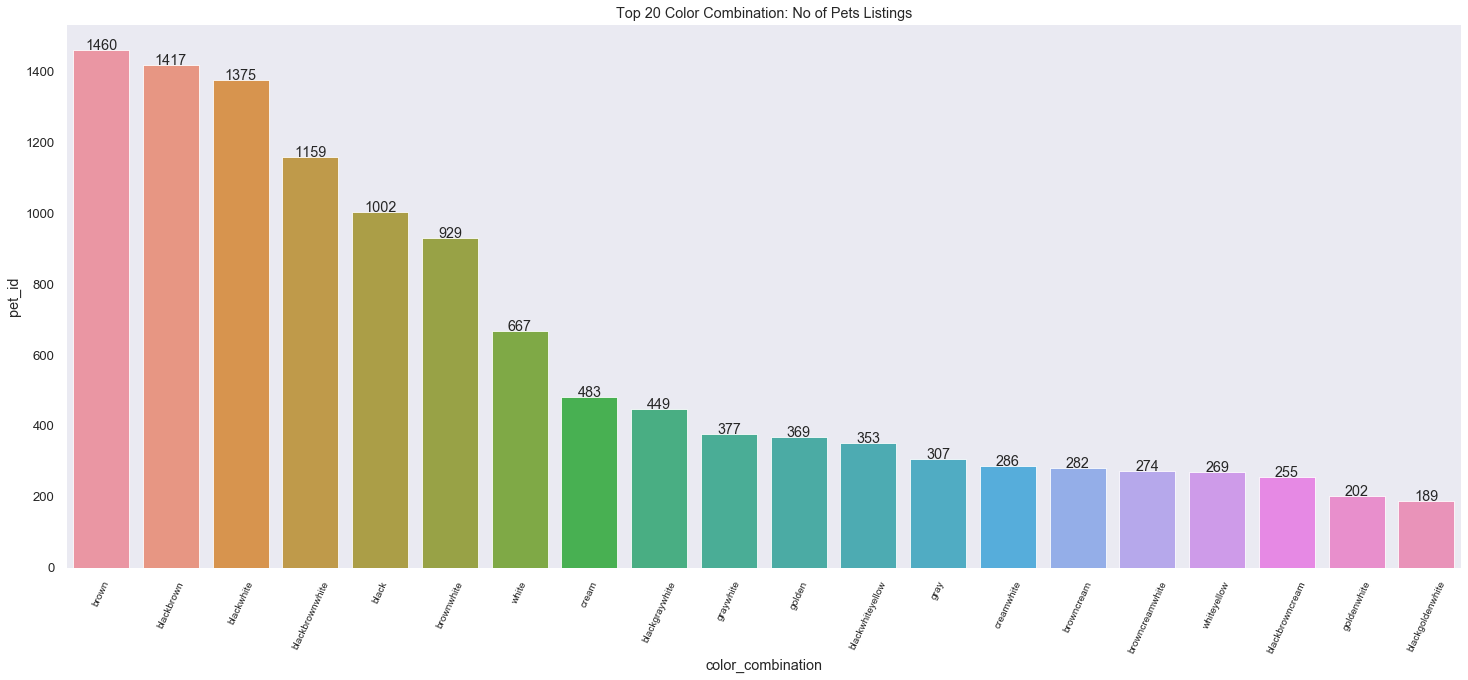

In [344]:
df_plot = petscopy[["color_combination", "pet_id"]].groupby(["color_combination"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar(df_plot.iloc[:20,:],
             "color_combination",
             "pet_id",
             "Top 20 Color Combination: No of Pets Listings",
             figsize=(25, 10),
             rotate=True)

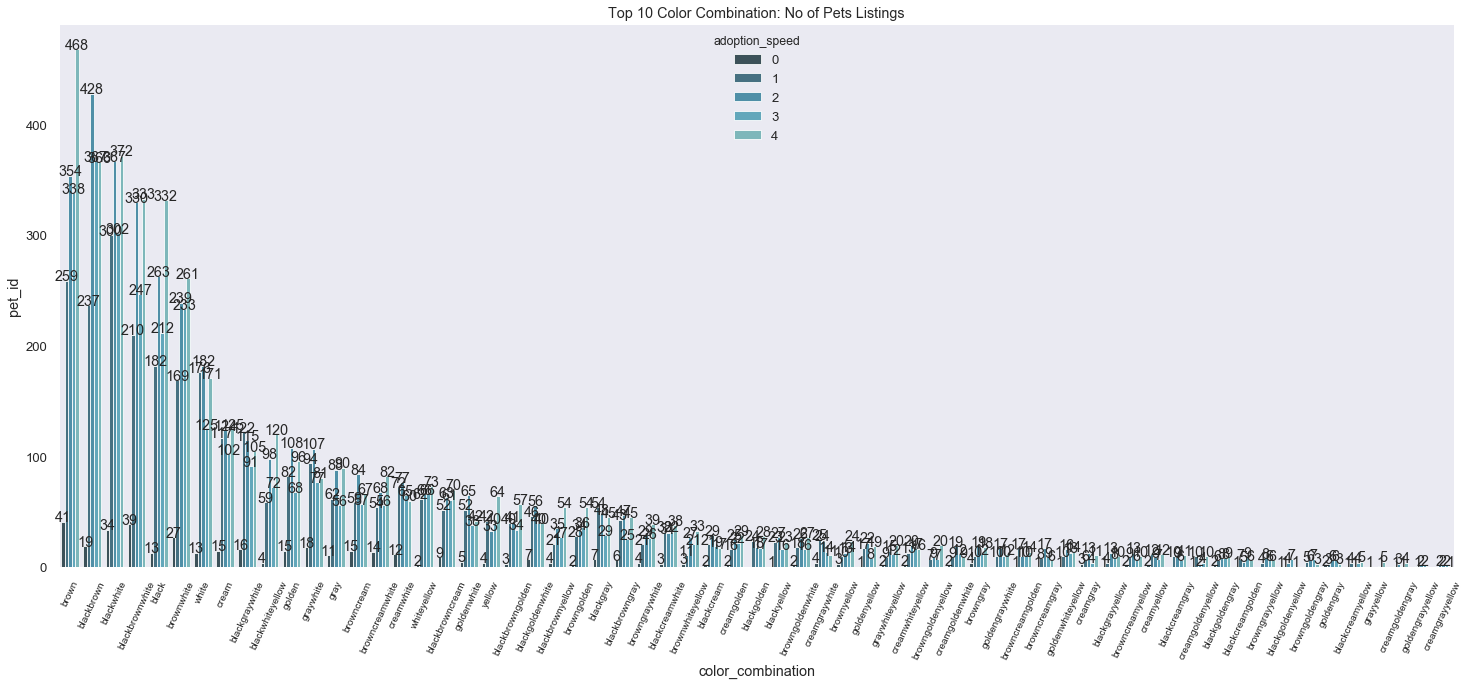

In [372]:
df_plot = petscopy[["color_combination", "adoption_speed", "pet_id"]].groupby([
    "color_combination", "adoption_speed"
]).count().sort_values("color_combination", ascending=False).reset_index().sort_values("pet_id", ascending=False)

pre.plot_bar_hue(df_plot,
                 "color_combination",
                 "pet_id",
                 "adoption_speed",
                 "Top 10 Color Combination: No of Pets Listings",
                 figsize=(25, 10),
                 rotate=True)

### Size at Maturity

(1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)

In [385]:
display(pd.DataFrame((pets.maturity_size.value_counts(normalize=True)*100)).head(20))

maturity_size
2  68.732075    
1  22.643900    
3  8.403922     
4  0.220103

### Fur Length

(1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)

In [386]:
display(pd.DataFrame((pets.fur_length.value_counts(normalize=True)*100)))

fur_length
1  58.747415 
2  35.756686 
3  5.495898

### Vaccinated

(1 = Yes, 2 = No, 3 = Not Sure)

In [387]:
display(pd.DataFrame((pets.vaccinated.value_counts(normalize=True)*100)))

vaccinated
2  48.202494 
1  39.338358 
3  12.459148

### Dewormed

(1 = Yes, 2 = No, 3 = Not Sure)

In [388]:
display(pd.DataFrame((pets.dewormed.value_counts(normalize=True)*100)))

dewormed
1  56.006136
2  32.114987
3  11.878877

### Spayed / Neutered

(1 = Yes, 2 = No, 3 = Not Sure)

In [390]:
display(pd.DataFrame((pets.sterilized.value_counts(normalize=True)*100)))

sterilized
2  67.211365 
1  20.682985 
3  12.105649

### Health Condition

(1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

In [391]:
display(pd.DataFrame((pets.health.value_counts(normalize=True)*100)))

health
1  96.565064
2  3.208164 
3  0.226772

### Quantity

In [393]:
display(pd.DataFrame((pets.quantity.value_counts(normalize=True)*100)))

quantity
1   77.135997
2   9.484426 
3   4.842260 
4   3.541653 
5   2.221036 
6   1.233909 
7   0.560261 
8   0.346829 
9   0.220103 
10  0.126726 
20  0.080037 
11  0.066698 
12  0.040019 
15  0.026679 
17  0.020009 
16  0.020009 
13  0.013340 
14  0.013340 
18  0.006670

### Adoption Fee

In [395]:
display(pd.DataFrame((pets.fee.value_counts(normalize=True)*100)))

fee
0    84.459414
50   3.121457 
100  2.721270 
200  1.460682 
150  1.080504 
..        ... 
210  0.006670 
99   0.006670 
330  0.006670 
75   0.006670 
599  0.006670 

[74 rows x 1 columns]

### Location

State location in Malaysia

In [396]:
display(pd.DataFrame((pets.state_desc.value_counts(normalize=True)*100)))

state_desc
selangor         58.120456 
kuala_lumpur     25.645301 
pulau_pinang     5.622624  
johor            3.381578  
perak            2.801307  
negeri_sembilan  1.687454  
melaka           0.913760  
kedah            0.733676  
pahang           0.566931  
terengganu       0.173414  
sabah            0.146735  
kelantan         0.100047  
sarawak          0.086707  
labuan           0.020009

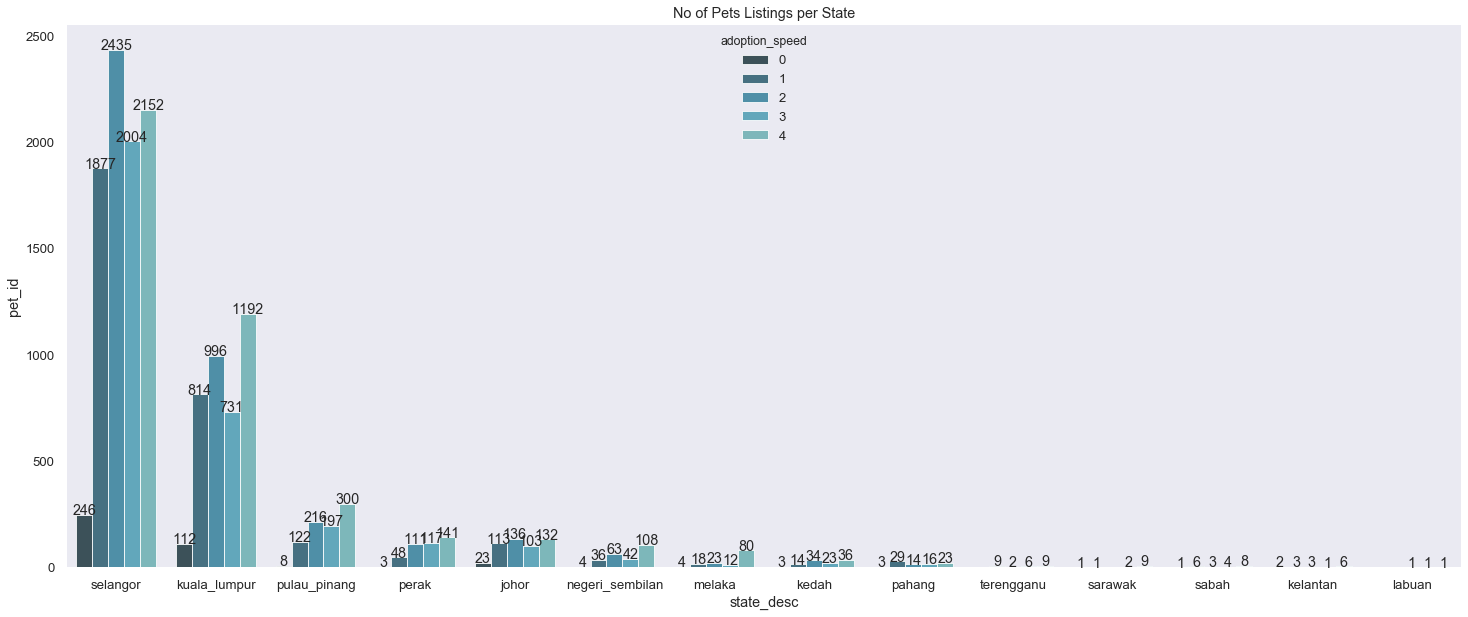

In [397]:
df_plot = pets[["state_desc", "adoption_speed",
                "pet_id"]].groupby(["state_desc", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "state_desc", "pet_id", "adoption_speed", 
             "No of Pets Listings per State", figsize = (25,10))

### Video Count

In [399]:
display(pd.DataFrame((pets.video_count.value_counts(normalize=True)*100)))

video_count
0  96.171547  
1  2.781298   
2  0.613620   
3  0.240112   
4  0.100047   
5  0.046688   
6  0.026679   
8  0.013340   
7  0.006670

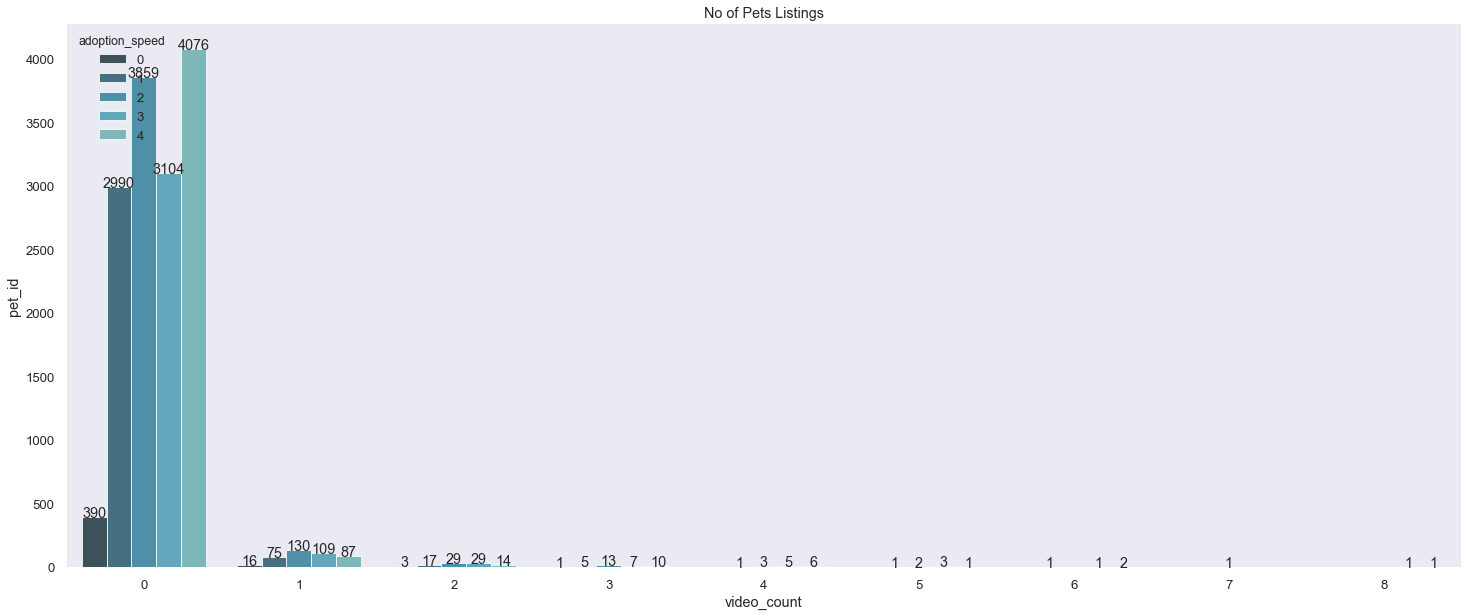

In [405]:
df_plot = pets[["video_count", "adoption_speed",
                "pet_id"]].groupby(["video_count", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "video_count", "pet_id", "adoption_speed", 
             "No of Pets Listings", figsize = (25,10))

### Photo Count

In [407]:
display(pd.DataFrame((pets.photo_count.value_counts(normalize=True)*100)))

photo_count
1.0   20.509571  
2.0   16.794504  
3.0   16.747816  
5.0   14.320016  
4.0   12.545855  
6.0   4.141933   
7.0   2.881345   
0.0   2.274395   
8.0   2.094311   
9.0   1.540719   
10.0  1.267258   
11.0  1.227239   
12.0  0.646969   
13.0  0.573601   
14.0  0.520243   
15.0  0.333489   
16.0  0.260121   
17.0  0.180084   
20.0  0.166744   
19.0  0.133396   
30.0  0.126726   
18.0  0.120056   
21.0  0.106716   
24.0  0.100047   
23.0  0.080037   
26.0  0.066698   
22.0  0.060028   
25.0  0.053358   
28.0  0.046688   
27.0  0.040019   
29.0  0.040019

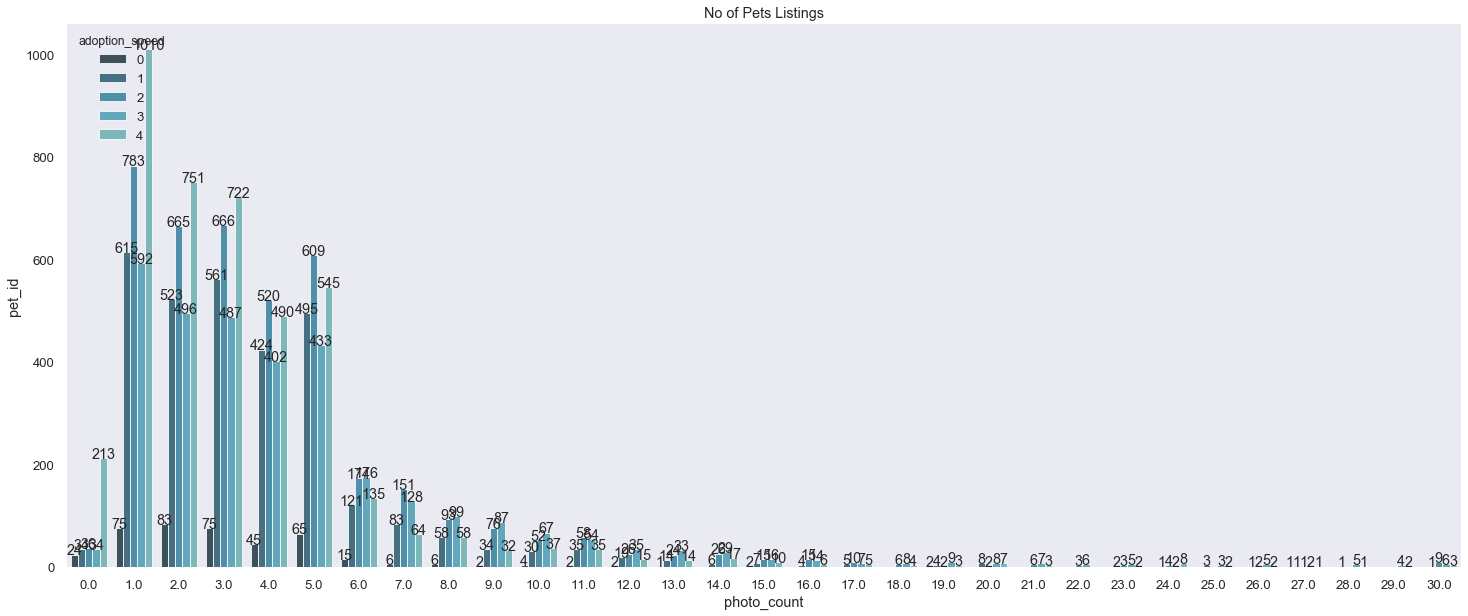

In [408]:
df_plot = pets[["photo_count", "adoption_speed",
                "pet_id"]].groupby(["photo_count", "adoption_speed"]).count().sort_values(
                    "pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot, "photo_count", "pet_id", "adoption_speed", 
             "No of Pets Listings", figsize = (25,10))

### Description

Note:  Google NLP API was used for the sentiment analysis of the . 

* Score corresponds to the overall emotional leaning of the description. 
    - 0.25 to 1 is positive
    - -0.25 to 0.25 is neutral
    - -1 to -0.25 is negative
* Magnitude indicates the overall strength of emotion (positive or negative). Longer text blocks may have higher magnitude.

Below is the example of sentiment analysis using description of pet_id a83d95ead.

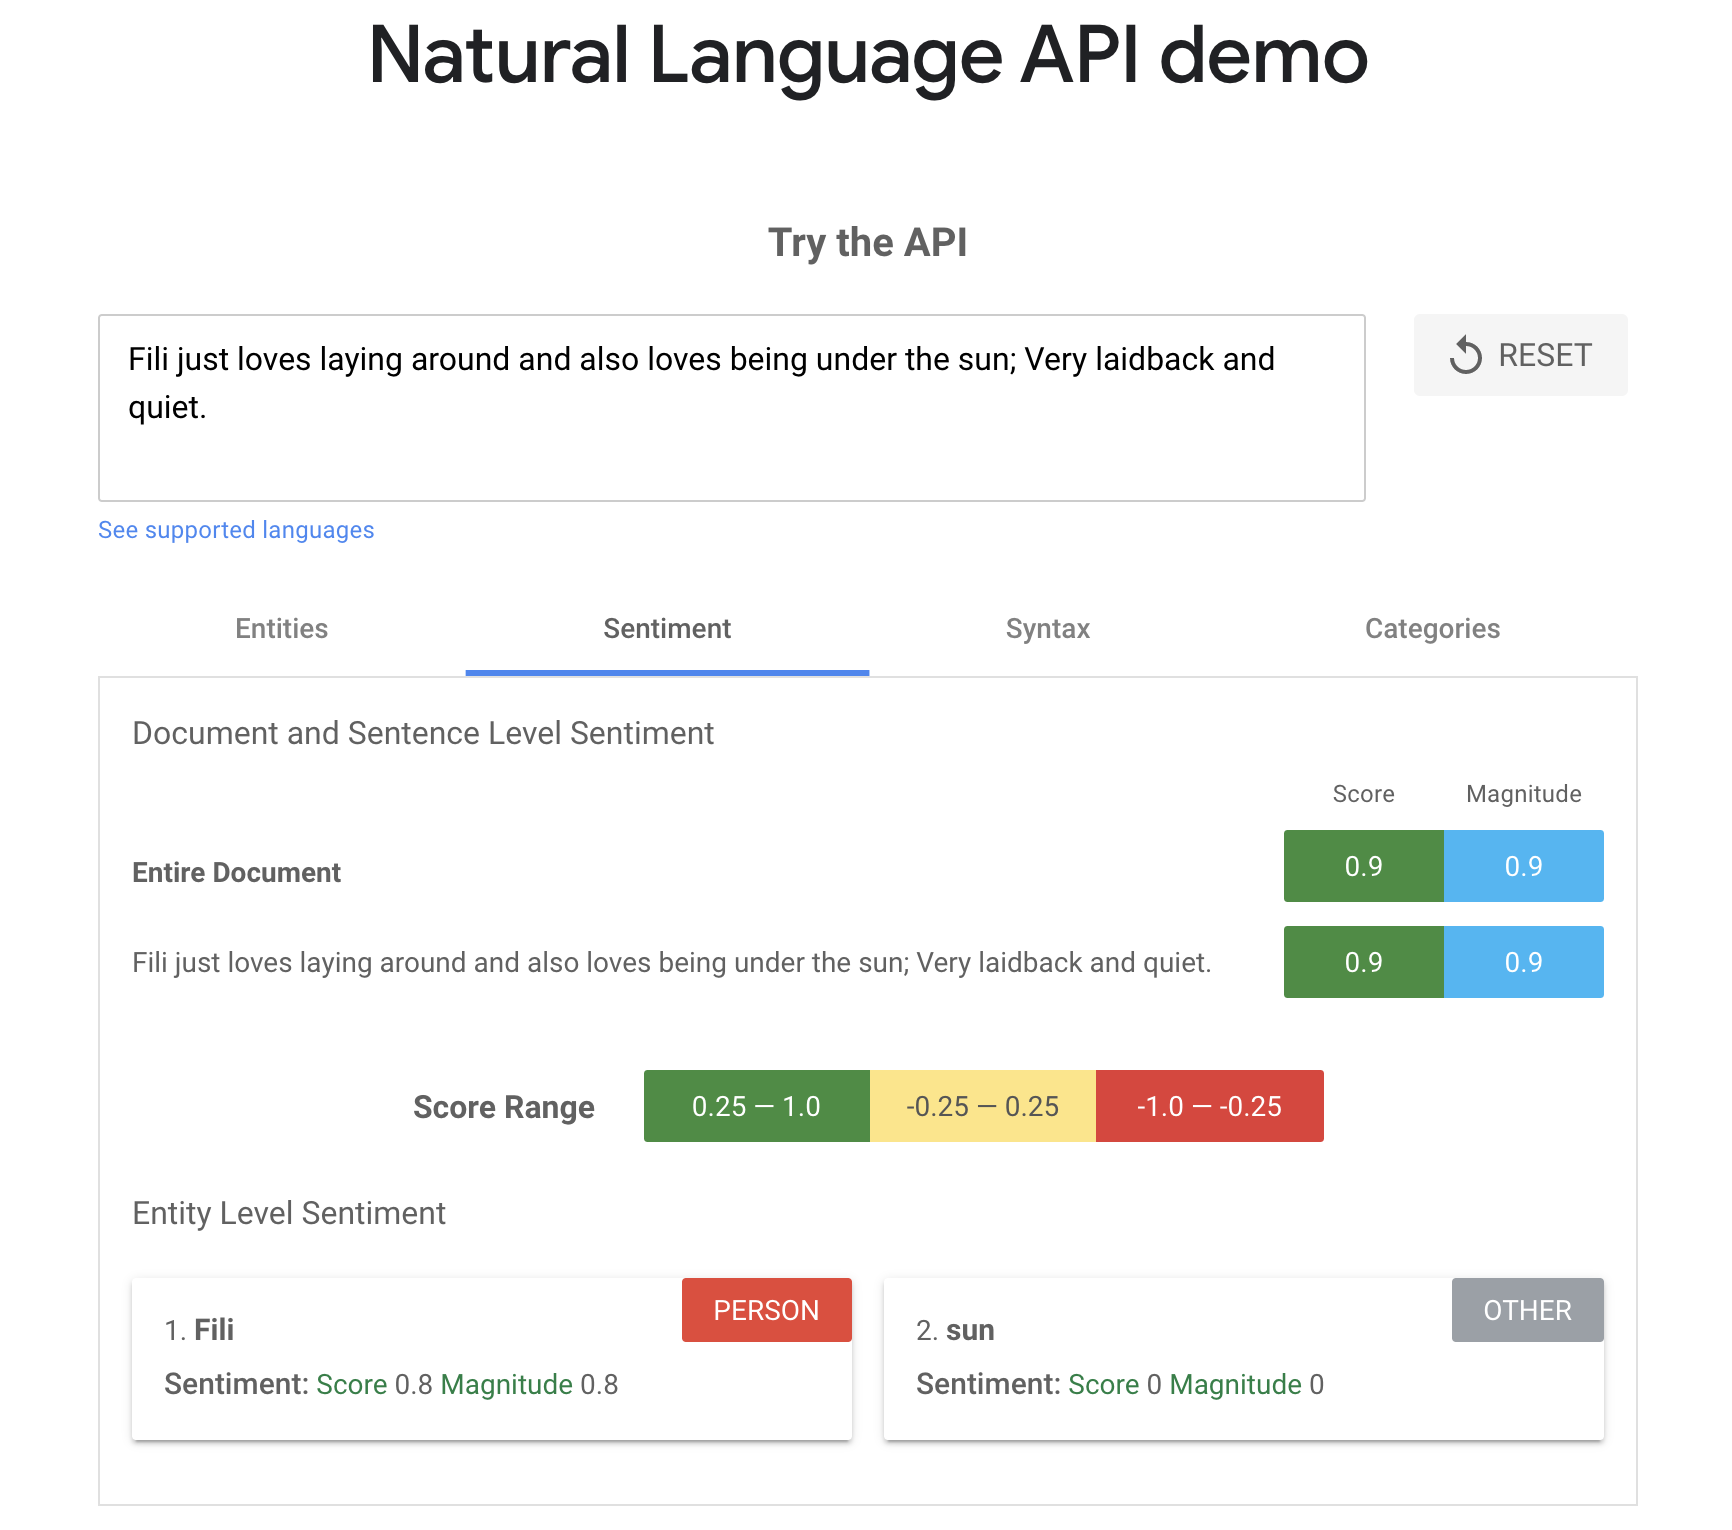

In [307]:
pre.get_image("dataset/", "fili.png")

In [309]:
pets.query("desc_score >= 0.25")[[
    "pet_id", "description", "desc_score", "adoption_speed"
]].sort_values("desc_score", ascending=False)

pet_id  \
14992  a83d95ead   
2878   082b9a2de   
12216  133234595   
12211  bcd23d8c3   
7925   be4275440   
...          ...   
9353   5fc6599fc   
9358   41ce762ce   
2307   8581566cb   
9370   a868df43f   
0      86e1089a3   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           description  \
14992  Fili just loves laying around and also loves being under the sun; Very laidback and quiet.                                                                                                                                                                                                                                                                                                                                                                                                                                        
2878   Indoor and litter trained kitten with great personalities; cute, cuddly, cheeky and playful.                                                                                                                                                                                                                                                                                                                                                                                                                                      
12216  Saw this pet near my house.Very cute puppies.Not sure what breed but need some good people to adopt them                                                                                                                                                                                                                                                                                                                                                                                                                          
12211  cheerful, playful, hyper active, litter trained, and adorable,                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
7925   She is healthy and very beautiful and when she was 3 weeks years old I found her without her mother                                                                                                                                                                                                                                                                                                                                                                                                                               
...                                                                                                    ...                                                                                                                                                                                                                                                                                                                                                                                                                               
9353   She's so active. So playful and need new house. Currently I got 5 cats to look after. So I have to give away

In [111]:
dupe_desc = pets[pets.duplicated(["description", "quantity"], keep=False)]

dupe_desc[dupe_desc.description.isna() == False][[
    "pet_id", "age", "quantity", "description", "adoption_speed"]].sort_values("description").query("description ! = 'For Adoption'").query(
    "description ! = 'Dog 4 Adoption'").query(
        "description ! = 'Open for adoption!!!'").query("description ! = '-'")

pet_id  age  quantity  \
8409   1ccd49ce2  24   1          
4520   7ddf00d90  24   1          
2418   f68a56b90  24   1          
11577  d69a1f2a1  3    1          
8587   fd7ae9b79  3    1          
...          ... ..   ..          
5432   79799da25  10   1          
5672   c37d5c957  6    1          
7072   68c69f5c1  7    1          
1182   972fba985  9    1          
8212   bd485150e  6    1          

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      description  \
8409   "This dog is one of the dogs rescued from the Klang Pound in April just before D-day (when they are put to death). It has been rehabilitated and urgently needs a loving home as we have limited resources. It is unfortunate that due to the aggressiveness of the contracted dogcatchers, most of these beautiful dogs are not strays and previously had homes. Hence, most of them are sociable and loving. Serving the voiceless, SAS Volunteer. P/s: Please contact Jackie by calling or texting her at, she's a grandma at emails. "   
4520   "This dog is one of the dogs rescued from the Klang Pound in April just before D-day (when they are put to death). It has been rehabilitated and urgently needs a loving home as we have limited resources. It is unfortunate that due to the aggressiveness of the contracted dogcatchers, most of these beautiful dogs are not strays and previously had homes. Hence, most of them are sociable and loving. Serving the voiceless, SAS Volunteer. P/s: Please contact Jackie by calling or texting her at, she's a grandma at emails. "   
2418   "This dog is one of the dogs rescued from the Klang Pound in April just before D-day (when they are put to death). It has been rehabilitated and urgently needs a loving home as we have limited resources. It is unfortunate that due to the aggressiveness of the contracted dogcatchers, most of these beautiful dogs are not strays and previously had homes. Hence, most of them are sociable and loving. Serving the voiceless, SAS Volunteer. P/s: Please contact Jackie by calling or texting her at, she's a grandma at emails. "   
11577  - 3 months old. - Female. - Blue eyed, white with black pattern. - Still shy with humans, but very playful with other kittens. We are now at Segambut, near Publika. Please let us know if you're interested to give her a permanent loving home.                                                                                                                                                                                                                                                                                            
8587   - 3 months old. - Female. - Blue eyed, white with black pattern. - Still shy with humans, but very playful with other kittens. We are now at Segambut, near Publika. Please let us know if you're interested to give her a permanent loving home.                                                                                                                                                                                                                                                                                            
...                                                                                                                                                                                                                                                  ...                                                                                                                                               

## Pre-processing

In [716]:
df = pd.read_csv("pets.csv")
pets = df.copy()
pets.shape

(14993, 33)

In [717]:
state_details = pd.read_csv("dataset/petfinder-adoption-prediction/Malaysian_States.csv")
state_details.head()

StateID     StateName  Population   Area  Population Density  \
0  41336    Johor         3233434     19210  168                  
1  41325    Kedah         1890098     9500   199                  
2  41367    Kelantan      1459994     15099  97                   
3  41401    Kuala Lumpur  1627172     243    6696                 
4  41415    Labuan        85272       91     937                  

   GDP_per_capita_2017  
0  34362                
1  20327                
2  13593                
3  111321               
4  65949

In [718]:
pets = pd.merge(pets, state_details, left_on= "state", right_on="StateID")
pets = pre.drop_columns(pets, ["StateID", "StateName"])
pets.columns = pets.columns.map(lambda x: x.lower())
pets.head()

adoption_speed     pet_id  type    name  age  breed1          breed1_desc  \
0  2               86e1089a3  2     Nibble  3    299     tabby                 
1  3               3422e4906  1     Brisco  1    307     mixed_breed           
2  2               850a43f90  1     Hunter  1    307     mixed_breed           
3  2               d24c30b4b  2     NaN     3    266     domestic_short_hair   
4  1               1caa6fcdb  2     BULAT   12   264     domestic_long_hair    

   breed2         breed2_desc  gender  color1 color1_desc  color2 color2_desc  \
0  0       NaN                 1       1       black       7       white        
1  0       NaN                 1       2       brown       7       white        
2  0       NaN                 1       1       black       0       NaN          
3  0       NaN                 2       5       cream       6       gray         
4  264     domestic_long_hair  1       1       black       0       NaN          

   color3 color3_desc  maturity_size  fur_length  vaccinated  dewormed  \
0  0       NaN         1              1           2           2          
1  0       NaN         2              2           1           1          
2  0       NaN         2              1           2           2          
3  0       NaN         2              1           2           2          
4  0       NaN         2              3           2           2          

   sterilized  health  quantity  fee  state state_desc  \
0  2           1       1         100  41326  selangor    
1  2           1       1         0    41326  selangor    
2  2           1       1         0    41326  selangor    
3  2           1       1         0    41326  selangor    
4  3           1       1         300  41326  selangor    

                         rescuer_id  video_count  photo_count  \
0  8480853f516546f6cf33aa88cd76c379  0            1.0           
1  fa90fa5b1ee11c86938398b60abc32cb  0            7.0           
2  95481e953f8aed9ec3d16fc4509537e8  0            3.0           
3  22fe332bf9c924d4718005891c63fbed  0            2.0           
4  1e0b5a458b5b77f5af581d57ebf570b3  0            3.0           

          filename  \
0  86e1089a3-1.jpg   
1  3422e4906-3.jpg   
2  850a43f90-1.jpg   
3  d24c30b4b-2.jpg   
4  1caa6fcdb-1.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                        description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.                                            
1  Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.          
2  This handsome yet cute boy is up for adoption. He is the most playful pal we've seen in our puppies. He loves to nibble on shoelaces , Chase you at such a young age. Imagine what a cute brat he will be when he grows. We are looking for a loving home for Hunter , one that will take care of him and give him the love that he needs. Please call urgently if you would like to adopt this cutie.             
3  This is a stray kitten that came to my house. Have been feeding it, but cannot keep it

In [464]:
# with open("dataset/petfinder-adoption-prediction/rating.json") as json_file:
#     breed_details = json.load(json_file)

In [492]:
# breed_details.keys

In [493]:
# cat_dict = breed_details["cat_breeds"]
# cat_dict.keys()

In [495]:
# cat_dict["Abyssinian"]

In [496]:
# dog_dict = breed_details["dog_breeds"]
# dog_dict.keys()

In [497]:
# dog_dict["Affenpinscher"]

In [498]:
# breeds_dict = {**dog_dict, **cat_dict}

In [499]:
# breeds_dict.keys()

In [500]:
# breed_details = pd.DataFrame()
# i = 0
# for breed in breeds_dict.keys():
#     breed_details.at[i,"breed"] = breed
#     for key in breeds_dict[breed].keys():
#         breed_details.at[i,key] = breeds_dict[breed][key] 
#     i = i+1
    
# breed_details

In [501]:
# breed_details.isna().sum()

In [719]:
print("Original shape = ", df.shape)
print("New shape = ", pets.shape)

Original shape =  (14993, 33)
New shape =  (14993, 37)


### Target variable

In [720]:
display(pd.DataFrame((pets.adoption_speed.value_counts(normalize=True)*100)).head(20))

adoption_speed
4  27.993063     
2  26.925899     
3  21.736811     
1  20.609618     
0  2.734609

In [721]:
pets.adoption_speed = pets.adoption_speed.map(lambda x: 1 if x == 0 else x)
display(pd.DataFrame((pets.adoption_speed.value_counts(normalize=True)*100)).head(20))

adoption_speed
4  27.993063     
2  26.925899     
1  23.344227     
3  21.736811

### Categorical Features with Not Specified or Not Sure category

* MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
* FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
* Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
* Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
* Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
* Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)

In [723]:
#MaturitySize - Size at maturity (1 = Small, 2 = Medium, 3 = Large, 4 = Extra Large, 0 = Not Specified)
display(pd.DataFrame((pets.maturity_size.value_counts(normalize=True)*100)))

maturity_size
2  68.732075    
1  22.643900    
3  8.403922     
4  0.220103

In [725]:
#FurLength - Fur length (1 = Short, 2 = Medium, 3 = Long, 0 = Not Specified)
display(pd.DataFrame((pets.fur_length.value_counts(normalize=True)*100)))

fur_length
1  58.747415 
2  35.756686 
3  5.495898

In [726]:
#Vaccinated - Pet has been vaccinated (1 = Yes, 2 = No, 3 = Not Sure)
display(pd.DataFrame((pets.vaccinated.value_counts(normalize=True)*100)))

vaccinated
2  48.202494 
1  39.338358 
3  12.459148

In [727]:
pets.vaccinated = pets.vaccinated.map(lambda x: 1 if x == 1 else 0)
display(pd.DataFrame((pets.vaccinated.value_counts(normalize=True)*100)))

vaccinated
0  60.661642 
1  39.338358

In [728]:
#Dewormed - Pet has been dewormed (1 = Yes, 2 = No, 3 = Not Sure)
display(pd.DataFrame((pets.dewormed.value_counts(normalize=True)*100)))

dewormed
1  56.006136
2  32.114987
3  11.878877

In [729]:
pets.dewormed = pets.dewormed.map(lambda x: 1 if x == 1 else 0)
display(pd.DataFrame((pets.dewormed.value_counts(normalize=True)*100)))

dewormed
1  56.006136
0  43.993864

In [730]:
#Sterilized - Pet has been spayed / neutered (1 = Yes, 2 = No, 3 = Not Sure)
display(pd.DataFrame((pets.sterilized.value_counts(normalize=True)*100)))

sterilized
2  67.211365 
1  20.682985 
3  12.105649

In [731]:
pets.sterilized = pets.sterilized.map(lambda x: 1 if x == 1 else 0)
display(pd.DataFrame((pets.sterilized.value_counts(normalize=True)*100)))

sterilized
0  79.317015 
1  20.682985

In [732]:
#Health - Health Condition (1 = Healthy, 2 = Minor Injury, 3 = Serious Injury, 0 = Not Specified)
display(pd.DataFrame((pets.health.value_counts(normalize=True)*100)))

health
1  96.565064
2  3.208164 
3  0.226772

In [733]:
print("Original shape = ", df.shape)
print("New shape = ", pets.shape)

Original shape =  (14993, 33)
New shape =  (14993, 37)


### Duplicates, zero and null values

In [734]:
#Remove 0 age for adoption speed rate 3 & 4
no_age = pets.query("age == 0").query("adoption_speed > 2").index
pets = pre.drop_rows(pets, no_age)

#Remove those with no description
no_desc = pets[pets.description.isna() == True].index
pets = pre.drop_rows(pets, no_desc)
no_desc_analysis = pets[pets.desc_score.isna() == True].index
pets = pre.drop_rows(pets, no_desc_analysis)

pets.reset_index(drop = True, inplace=True)

print("Original shape = ", df.shape)
print("New shape = ", pets.shape)

Original shape =  (14993, 33)
New shape =  (14373, 37)


In [735]:
pets.sort_values("age",ascending=False)

adoption_speed     pet_id  type                               name  \
12210  4               5971c2462  1     Happy-FIFI                          
12376  4               50682d0f1  1     FiFi                                
13218  4               e01f077a7  1     Enzo                                
11557  4               36d7fc2c5  1     Snow                                
11143  3               e77f9e778  2     Three Kittens                       
...   ..                     ... ..               ...                       
4666   2               20c3c2ba7  1     Disney                              
4930   1               10949ac80  1     Jack Russell Mix Breed              
5691   2               4dc593f4e  1     Cute Pups Urgently Need Re - Home   
13733  1               c6c6adc4a  1     Cute Puppy1                         
11189  2               e5e06c8dd  1     Survivor                            

       age  breed1           breed1_desc  breed2          breed2_desc  gender  \
12210  255  307     mixed_breed           0       NaN                  1        
12376  255  307     mixed_breed           0       NaN                  1        
13218  238  307     mixed_breed           0       NaN                  1        
11557  212  307     mixed_breed           0       NaN                  2        
11143  212  266     domestic_short_hair   266     domestic_short_hair  3        
...    ...  ...                     ...   ...                     ... ..        
4666   0    307     mixed_breed           307     mixed_breed          1        
4930   0    128     jack_russell_terrier  0       NaN                  3        
5691   0    307     mixed_breed           307     mixed_breed          3        
13733  0    307     mixed_breed           307     mixed_breed          2        
11189  0    50      bullmastiff           307     mixed_breed          2        

       color1 color1_desc  color2 color2_desc  color3 color3_desc  \
12210  2       brown       7       white       0       NaN          
12376  2       brown       7       white       0       NaN          
13218  7       white       0       NaN         0       NaN          
11557  7       white       0       NaN         0       NaN          
11143  1       black       5       cream       7       white        
...   ..         ...      ..         ...      ..         ...        
4666   7       white       0       NaN         0       NaN          
4930   7       white       0       NaN         0       NaN          
5691   1       black       7       white       0       NaN          
13733  1       black       5       cream       7       white        
11189  2       brown       0       NaN         0       NaN          

       maturity_size  fur_length  vaccinated  dewormed  sterilized  health  \
12210  2              2           0           0         0           1        
12376  2              2           0           0         0           1        
13218  2              1           1           1         1           1        
11557  2              1           0           0         0           1        
11143  1              1           1           1         0           1        
...   ..             ..          ..          ..        ..          ..        
4666   2              1           1           1         0           1        
4930   2              1           0           0         0           1        
5691   2              1           0           0         0           1        
13733  2              1           0           0         0           1        
11189  2              1           0           0         0           1        

       quantity  fee  state    state_desc                        rescuer_id  \
12210  1         0    41330  perak         94fdeec413a441bca0de9e9887edcc70   
12376  1         0    41330  perak         94fdeec413a441bca0de9e9887edcc70   
13218  1         0    41327  pulau_pinang  b39c5db7a450d0f3437ada1df3554db6   
11557  1         0    41401

In [736]:
pets = pre.drop_rows(pets, [12376])

In [737]:
pets.sort_values("age",ascending=False)

adoption_speed     pet_id  type                   name  age  breed1  \
12210  4               5971c2462  1     Happy-FIFI             255  307      
13218  4               e01f077a7  1     Enzo                   238  307      
12172  3               53923463d  2     Kitkat                 212  266      
11143  3               e77f9e778  2     Three Kittens          212  266      
11557  4               36d7fc2c5  1     Snow                   212  307      
...   ..                     ... ..      ...                   ...  ...      
121    1               ba66a7a82  2     2-3 Week Old Kittens   0    292      
5714   2               244144067  1     River Bank Pups        0    307      
778    2               85114144b  2     Oren-oren (Both Male)  0    266      
7246   1               60bc5ce92  1     Pupssssss NEED LOVE    0    307      
3773   2               2c23cf72e  1     Amber                  0    307      

               breed1_desc  breed2          breed2_desc  gender  color1  \
12210  mixed_breed          0       NaN                  1       2        
13218  mixed_breed          0       NaN                  1       7        
12172  domestic_short_hair  0       NaN                  2       1        
11143  domestic_short_hair  266     domestic_short_hair  3       1        
11557  mixed_breed          0       NaN                  2       7        
...            ...         ..       ...                 ..      ..        
121    siamese              299     tabby                3       2        
5714   mixed_breed          0       NaN                  3       2        
778    domestic_short_hair  0       NaN                  1       4        
7246   mixed_breed          0       NaN                  3       1        
3773   mixed_breed          0       NaN                  2       4        

      color1_desc  color2 color2_desc  color3 color3_desc  maturity_size  \
12210  brown       7       white       0       NaN         2               
13218  white       0       NaN         0       NaN         2               
12172  black       0       NaN         0       NaN         2               
11143  black       5       cream       7       white       1               
11557  white       0       NaN         0       NaN         2               
...      ...      ..       ...        ..       ...        ..               
121    brown       5       cream       0       NaN         2               
5714   brown       5       cream       0       NaN         2               
778    yellow      5       cream       0       NaN         2               
7246   black       2       brown       0       NaN         1               
3773   yellow      7       white       0       NaN         1               

       fur_length  vaccinated  dewormed  sterilized  health  quantity  fee  \
12210  2           0           0         0           1       1         0     
13218  1           1           1         1           1       1         0     
12172  1           1           1         0           1       1         0     
11143  1           1           1         0           1       3         0     
11557  1           0           0         0           1       1         0     
...   ..          ..          ..        ..          ..      ..        ..     
121    1           0           0         0           2       3         0     
5714   1           0           0         0           1       2         0     
778    1           0           0         0           1       2         0     
7246   1           0           0         0           1       9         0     
3773   2           0           0         0           1       1         0     

       state    state_desc                        rescuer_id  video_count  \
12210  41330  perak         94fdeec413a441bca0de9e9887edcc70  0             
13218  41327  pulau_pinang  b39c5db7a450d0f3437ada1df3554db6  0             
12172  41330  perak         60689896aa0edff3a4f05b890bdafd26  1             
11143  4140

### Other Categorical features

As there are 307 possible values for breeds and they do not have a natural ordering, I will bin and order the breeds based on how fast they are adopted.

Since Mixed Breed and Domestic are the most common values, I will categorised breed into these 3:
1. Pure Bred Non-Domestic
2. Pure Bred Domestic 
3. Mixed Bred

State and color columns do not have a natural ordering as well.  As the possible values are only 15 and 7, respectively, I will instead convert these into dummy variables.

In [738]:
pets = pre.bin_breed(pets)
print("Original shape = ", df.shape)
print("New shape = ", pets.shape)

Original shape =  (14993, 33)
New shape =  (14372, 39)


In [739]:
pets[["breed_bin", "breed1_desc", "breed2_desc"]].sample(10)

breed_bin           breed1_desc breed2_desc
2302   2.0        domestic_short_hair   NaN       
12194  1.0        spitz                 NaN       
6031   2.0        domestic_medium_hair  NaN       
11006  1.0        english_bulldog       NaN       
2891   3.0        mixed_breed           NaN       
2262   3.0        mixed_breed           NaN       
9207   2.0        domestic_short_hair   NaN       
6735   2.0        domestic_short_hair   NaN       
12861  3.0        mixed_breed           NaN       
12835  1.0        terrier               NaN

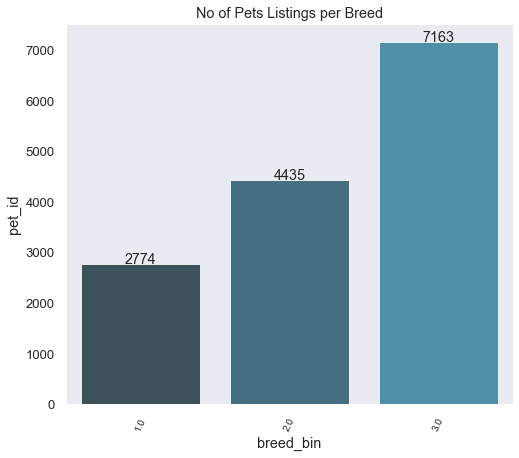

In [740]:
df_plot = pets[["breed_bin",
                "pet_id"]].groupby("breed_bin").count().sort_values(
                    "pet_id", ascending=False).iloc[:10, ].reset_index()
pre.plot_bar(df_plot, "breed_bin", "pet_id",
             "No of Pets Listings per Breed", rotate = True)

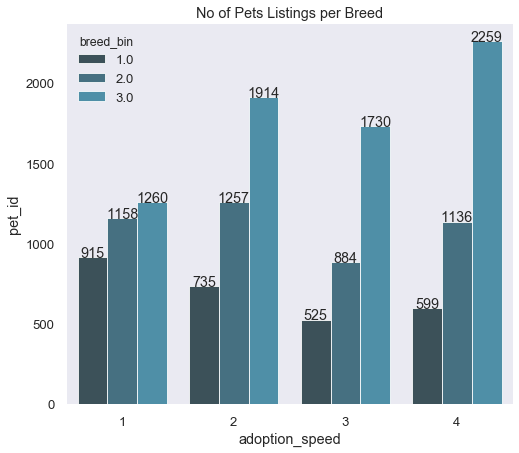

In [741]:
df_plot = pets[["breed_bin", "adoption_speed", "pet_id"]].groupby(["breed_bin", "adoption_speed"]).count().sort_values("pet_id", ascending=False).reset_index()
pre.plot_bar_hue(df_plot,"adoption_speed", "pet_id", "breed_bin", "No of Pets Listings per Breed", rotate = False)

In [742]:
check = pd.merge(pets[["breed_bin", "adoption_speed", "pet_id"]].groupby([
    "breed_bin", "adoption_speed"
]).count().sort_values(["breed_bin", "adoption_speed"]).reset_index(),
                 pets[["breed_bin", "pet_id"
                            ]].groupby(["breed_bin"]).count().reset_index(),
                 on="breed_bin")
check["ratio"] = check["pet_id_x"] / check["pet_id_y"]

print("AdoptionSpeed 0-2")
display(check[["breed_bin", "adoption_speed", "ratio"
               ]].query("adoption_speed < 3").groupby("breed_bin").sum()[[
                   "ratio"
               ]].sort_values("ratio", ascending=False))

print("Adoption Speed 3&4")
display(check[["breed_bin", "adoption_speed", "ratio"
               ]].query("adoption_speed > 2").groupby("breed_bin").sum()[[
                   "ratio"
               ]].sort_values("ratio"))

AdoptionSpeed 0-2


ratio
breed_bin          
1.0        0.594809
2.0        0.544532
3.0        0.443110

Adoption Speed 3&4


ratio
breed_bin          
1.0        0.405191
2.0        0.455468
3.0        0.556890

In [743]:
pets.breed_bin = pets.breed_bin.astype("int64")
display(pd.DataFrame((pets.breed_bin.value_counts(normalize=True)*100)).head(20))

breed_bin
3  49.839967
2  30.858614
1  19.301419

Based on the above tables, breed 1 has the highest percentage of listings adopted within a month and also has the lowest for more than a month.  Moreover, the orders for both tables are the same hence the binning method works.

In [744]:
pets.type  = pets.type.map(lambda x: "dog" if x == 1 else "cat")
display(pd.DataFrame((pets.type.value_counts(normalize=True)*100)))

type
dog  56.046479
cat  43.953521

In [745]:
#### Convert age into categorical
pets.age = pets.age.map(lambda x: 1 if x <= 12 else 0)
pets.rename(mapper={"age": "age_0-12mos",}, axis=1, inplace=True)
display(pd.DataFrame((pets["age_0-12mos"].value_counts(normalize=True)*100)))

age_0-12mos
1  81.185639  
0  18.814361

In [746]:
pets = pre.color_dummies(pets)
print("New shape = ", pets.shape)

New shape =  (14372, 45)


In [747]:
pets = pd.get_dummies(pets, prefix="state", columns = ["state_desc"], drop_first = True, dtype = "float64")
print("New shape = ", pets.shape)

New shape =  (14372, 57)


In [748]:
col_cat = ["type", "breed_bin", "gender"]
pets = pd.get_dummies(pets, columns = col_cat, drop_first = True, dtype = "float64")
print("New shape = ",  pets.shape)

New shape =  (14372, 59)


In [749]:
col_excl = [
    "name", "state", "rescuer_id", "breed1", "breed1_desc", "breed2",
    "breed2_desc", "color1", "color1_desc", "color2", "color2_desc", "color3",
    "color3_desc", "check"
]
pets = pre.drop_columns(pets, col_excl)

pets.rename(mapper={
    "gender_2": "gender_female",
    "gender_3": "gender_mixed",
    "breed_bin_2": "breed_domestic",
    "breed_bin_3": "breed_mixed"
},
            axis=1,
            inplace=True)

print("New shape = ", pets.shape)
pets.head(2)

New shape =  (14372, 45)


adoption_speed     pet_id  age_0-12mos  maturity_size  fur_length  \
0  2               86e1089a3  1            1              1            
1  3               3422e4906  1            2              2            

   vaccinated  dewormed  sterilized  health  quantity  fee  video_count  \
0  0           0         0           1       1         100  0             
1  1           1         0           1       1         0    0             

   photo_count         filename  \
0  1.0          86e1089a3-1.jpg   
1  7.0          3422e4906-3.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                 description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.                                     
1  Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.   

   desc_score  desc_magnitude  population  area  population density  \
0  0.3         2.4             5411324     8104  668                  
1  0.2         3.7             5411324     8104  668                  

   gdp_per_capita_2017  color_brown  color_cream  color_golden  color_gray  \
0  48091                0.0          0.0          0.0           0.0          
1  48091                1.0          0.0          0.0           0.0          

   color_white  color_yellow  state_kedah  state_kelantan  state_kuala_lumpur  \
0  1.0          0.0           0.0          0.0             0.0                  
1  1.0          0.0           0.0          0.0             0.0                  

   state_labuan  state_melaka  state_negeri_sembilan  state_pahang  \
0  0.0           0.0           0.0                    0.0            
1  0.0           0.0           0.0                    0.0            

   state_perak  state_pulau_pinang  state_sabah  state_sarawak  \
0  0.0          0.0                 0.0          0.0             
1  0.0          0.0                 0.0          0.0             

   state_selangor  state_terengganu  type_dog  breed_domestic  breed_mixed  \
0  1.0             0.0               0.0       0.0             0.0           
1  1.0             0.0               1.0       0.0             1.0           

   gender_female  gender_mixed  
0  0.0            0.0           
1  0.0            0.0

In [750]:
pets.isna().sum()

adoption_speed           0  
pet_id                   0  
age_0-12mos              0  
maturity_size            0  
fur_length               0  
vaccinated               0  
dewormed                 0  
sterilized               0  
health                   0  
quantity                 0  
fee                      0  
video_count              0  
photo_count              0  
filename                 321
description              0  
desc_score               0  
desc_magnitude           0  
population               0  
area                     0  
population density       0  
gdp_per_capita_2017      0  
color_brown              0  
color_cream              0  
color_golden             0  
color_gray               0  
color_white              0  
color_yellow             0  
state_kedah              0  
state_kelantan           0  
state_kuala_lumpur       0  
state_labuan             0  
state_melaka             0  
state_negeri_sembilan    0  
state_pahang             0  
state_perak   

### Interactions

In [752]:
pets.to_csv("pets_model.csv", index=False)

In [753]:
interaction_health = ["vaccinated", "dewormed", "sterilized", "health"]
interaction_state = ["population", "area", "population density", "gdp_per_capita_2017"]
interaction_sentiment = ["desc_score", "desc_magnitude"]

X_interaction_health = pre.get_interaction(pets, interaction_health, 3)
X_interaction_state = pre.get_interaction(pets, interaction_state, 3)
X_interaction_sentiment = pre.get_interaction(pets, interaction_sentiment, 2)

In [754]:
pets_interactions = pre.drop_columns(
    pets, interaction_health + interaction_state + interaction_sentiment)

pets_model = pd.concat([
    pets_interactions, X_interaction_health, X_interaction_state,
    X_interaction_sentiment
],
                       axis=1)

pets_model.head()

adoption_speed     pet_id  age_0-12mos  maturity_size  fur_length  \
0  2               86e1089a3  1            1              1            
1  3               3422e4906  1            2              2            
2  2               850a43f90  1            2              1            
3  2               d24c30b4b  1            2              1            
4  1               1caa6fcdb  1            2              3            

   quantity  fee  video_count  photo_count         filename  \
0  1         100  0            1.0          86e1089a3-1.jpg   
1  1         0    0            7.0          3422e4906-3.jpg   
2  1         0    0            3.0          850a43f90-1.jpg   
3  1         0    0            2.0          d24c30b4b-2.jpg   
4  1         300  0            3.0          1caa6fcdb-1.jpg   

                                                                                                                                                                                                                                                                                                                                                                                                        description  \
0  Nibble is a 3+ month old ball of cuteness. He is energetic and playful. I rescued a couple of cats a few months ago but could not get them neutered in time as the clinic was fully scheduled. The result was this little kitty. I do not have enough space and funds to care for more cats in my household. Looking for responsible people to take over Nibble's care.                                            
1  Their pregnant mother was dumped by her irresponsible owner at the roadside near some shops in Subang Jaya. Gave birth to them at the roadside. They are all healthy and adorable puppies. Already dewormed, vaccinated and ready to go to a home. No tying or caging for long hours as guard dogs. However, it is acceptable to cage or tie for precautionary purposes. Interested to adopt pls call me.          
2  This handsome yet cute boy is up for adoption. He is the most playful pal we've seen in our puppies. He loves to nibble on shoelaces , Chase you at such a young age. Imagine what a cute brat he will be when he grows. We are looking for a loving home for Hunter , one that will take care of him and give him the love that he needs. Please call urgently if you would like to adopt this cutie.             
3  This is a stray kitten that came to my house. Have been feeding it, but cannot keep it.                                                                                                                                                                                                                                                                                                                            
4  anyone within the area of ipoh or taiping who interested to adopt my cat can contact my father at this number (mazuvil)or can just email me. currently bulat is at my hometown at perak but anyone outside the area still want to adopt can travel there to my hometown.there is a lot of cats in my house rite now..i think i should let one of them go to a better owner who can give better attention to him.   

   color_brown  color_cream  color_golden  color_gray  color_white  \
0  0.0          0.0          0.0           0.0         1.0           
1  1.0          0.0          0.0           0.0         1.0           
2  0.0          0.0          0.0           0.0         0.0           
3  0.0          1.0          0.0           1.0         0.0           
4  0.0          0.0          0.0           0.0         0.0           

   color_yellow  state_kedah  state_kelantan  state_kuala_lumpur  \
0  0.0           0.0          0.0             0.0                  
1  0.0           0.0          0.0             0.0                  
2  0.0           0.0          0.0             0.0                  
3  0.0           0.0          0.0             0.0      

In [755]:
pets_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14372 entries, 0 to 14372
Data columns (total 66 columns):
adoption_speed                                       14372 non-null int64
pet_id                                               14372 non-null object
age_0-12mos                                          14372 non-null int64
maturity_size                                        14372 non-null int64
fur_length                                           14372 non-null int64
quantity                                             14372 non-null int64
fee                                                  14372 non-null int64
video_count                                          14372 non-null int64
photo_count                                          14372 non-null float64
filename                                             14051 non-null object
description                                          14372 non-null object
color_brown                                          14372 non-null floa

In [756]:
pets_model.to_csv("pets_interactions.csv", index=False)

# Multi-class Problem

In [757]:
pets = pd.read_csv("pets_interactions.csv")
pets.shape

(14372, 66)

In [758]:
pets.columns

Index(['adoption_speed', 'pet_id', 'age_0-12mos', 'maturity_size',
       'fur_length', 'quantity', 'fee', 'video_count', 'photo_count',
       'filename', 'description', 'color_brown', 'color_cream', 'color_golden',
       'color_gray', 'color_white', 'color_yellow', 'state_kedah',
       'state_kelantan', 'state_kuala_lumpur', 'state_labuan', 'state_melaka',
       'state_negeri_sembilan', 'state_pahang', 'state_perak',
       'state_pulau_pinang', 'state_sabah', 'state_sarawak', 'state_selangor',
       'state_terengganu', 'type_dog', 'breed_domestic', 'breed_mixed',
       'gender_female', 'gender_mixed', 'vaccinated', 'dewormed', 'sterilized',
       'health', 'vaccinated_dewormed', 'vaccinated_sterilized',
       'vaccinated_health', 'dewormed_sterilized', 'dewormed_health',
       'sterilized_health', 'vaccinated_dewormed_sterilized',
       'vaccinated_dewormed_health', 'vaccinated_sterilized_health',
       'dewormed_sterilized_health', 'population', 'area',
       'population

In [759]:
target = ["adoption_speed"]
to_scale = [
    "video_count", "photo_count", "quantity", "fee", 'population', 'area',
    'population_density', 'gdp_per_capita_2017', 'population_area',
    'population_population_density', 'population_gdp_per_capita_2017',
    'area_population_density', 'area_gdp_per_capita_2017',
    'population_density_gdp_per_capita_2017',
    'population_area_population_density',
    'population_area_gdp_per_capita_2017',
    'population_population_density_gdp_per_capita_2017',
    'area_population_density_gdp_per_capita_2017', 'desc_score',
    'desc_magnitude', 'desc_score_desc_magnitude'
]
to_exclude = ["filename", "pet_id", "description"]

cat_feat = sorted(list(set(list(pets.columns)) - set(target + to_scale + to_exclude)))

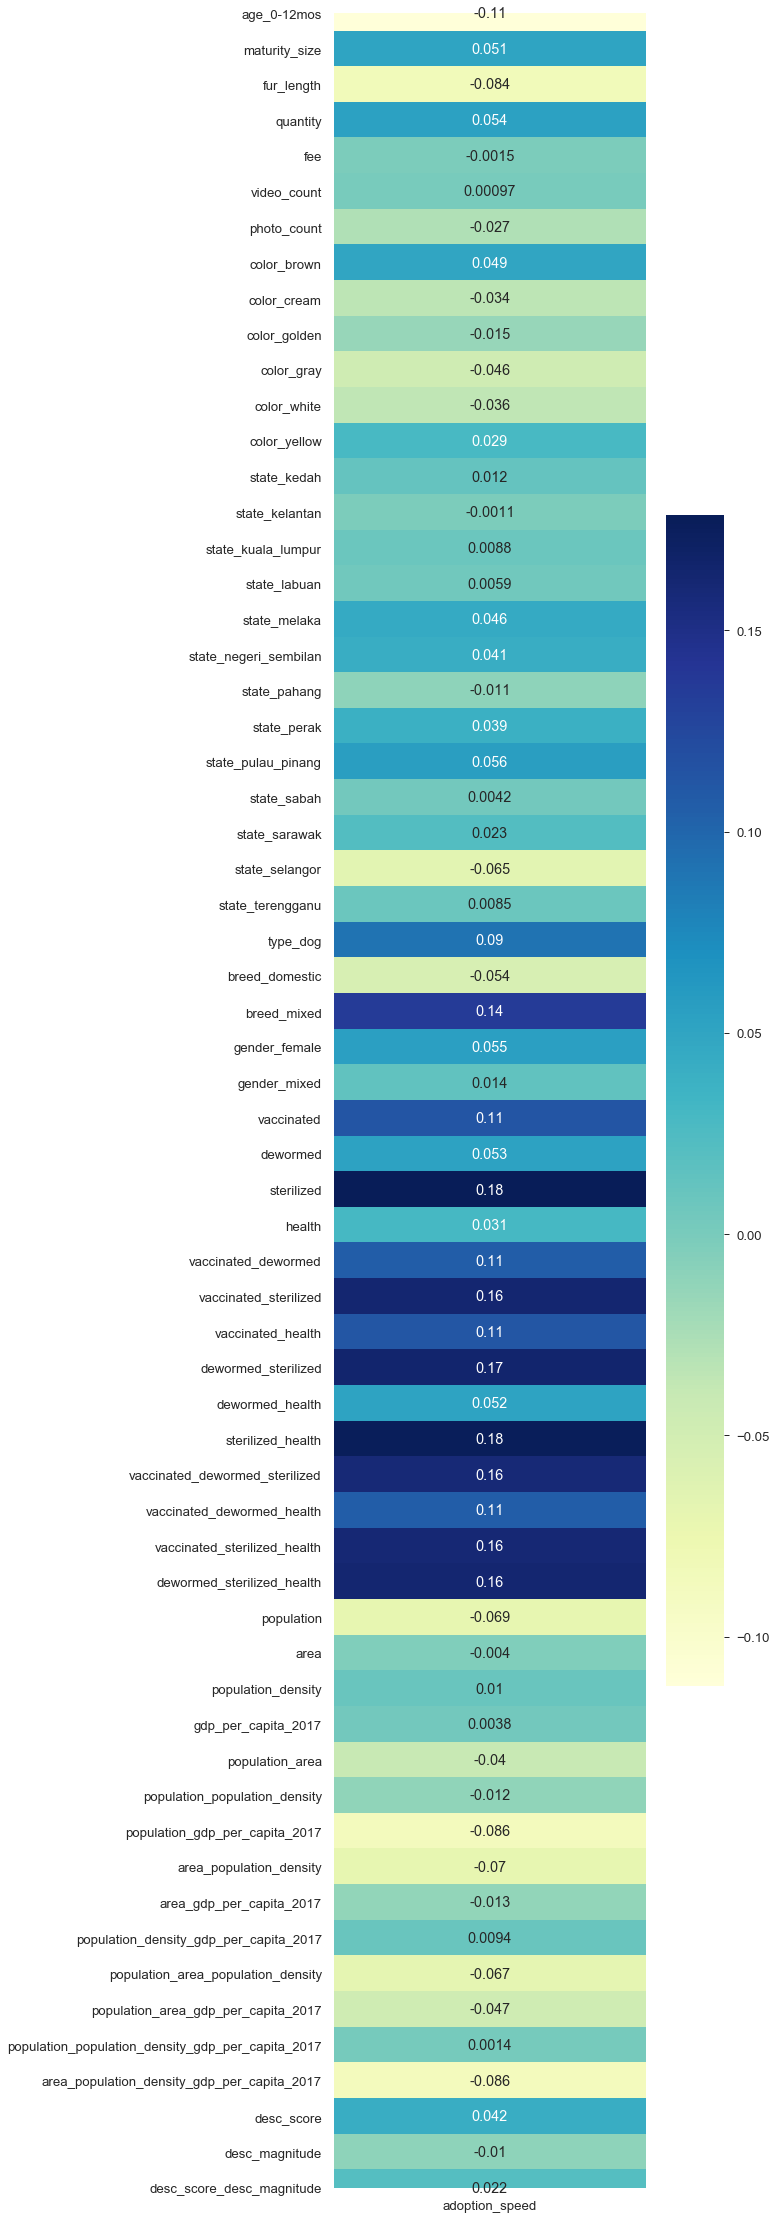

In [765]:
plt.figure(figsize=(7, 40))
sns.heatmap(data = pets.corr()[target].iloc[1:,:], annot=True, cmap="YlGnBu");

In [767]:
y = pets[target]
X = pre.drop_columns(pets, to_exclude+target)

In [769]:
X.columns

Index(['age_0-12mos', 'maturity_size', 'fur_length', 'quantity', 'fee',
       'video_count', 'photo_count', 'color_brown', 'color_cream',
       'color_golden', 'color_gray', 'color_white', 'color_yellow',
       'state_kedah', 'state_kelantan', 'state_kuala_lumpur', 'state_labuan',
       'state_melaka', 'state_negeri_sembilan', 'state_pahang', 'state_perak',
       'state_pulau_pinang', 'state_sabah', 'state_sarawak', 'state_selangor',
       'state_terengganu', 'type_dog', 'breed_domestic', 'breed_mixed',
       'gender_female', 'gender_mixed', 'vaccinated', 'dewormed', 'sterilized',
       'health', 'vaccinated_dewormed', 'vaccinated_sterilized',
       'vaccinated_health', 'dewormed_sterilized', 'dewormed_health',
       'sterilized_health', 'vaccinated_dewormed_sterilized',
       'vaccinated_dewormed_health', 'vaccinated_sterilized_health',
       'dewormed_sterilized_health', 'population', 'area',
       'population_density', 'gdp_per_capita_2017', 'population_area',
       'p

In [770]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [771]:
X_train_scaled, X_test_scaled = func.minmax_scaler(X_train, X_test, to_scale)

In [825]:
def score_clf(X_train, X_test, y_train, y_test, count, estimator, **kwargs):
    """
    Test various estimators.
    """

    model = estimator
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test_scaled)

    acc_score = accuracy_score(y_test, y_test_pred)
    cohen_kappa = cohen_kappa_score(y_test, y_test_pred, weights="quadratic")
    
    if estimator.__class__.__name__ == "OneVsRestClassifier":
        print("{}. OneVsRest {}:".format(count+1, estimator.estimator.__class__.__name__))
        print("Accuracy: {}".format(acc_score))
        print("Quadratic Cohen-Kappa Score: {}".format(cohen_kappa))
        print("\n")
        
    elif estimator.__class__.__name__ == "OneVsOneClassifier":
        print("{}. OneVsOne {}:".format(count+1, estimator.estimator.__class__.__name__))
        print("Accuracy: {}".format(acc_score))
        print("Quadratic Cohen-Kappa Score: {}".format(cohen_kappa))
        print("\n")
        
    else:
        print("{}. {}:".format(count+1, estimator.__class__.__name__))
        print("Accuracy: {}".format(acc_score))
        print("Quadratic Cohen-Kappa Score: {}".format(cohen_kappa))
        print("\n")
    
    return acc_score, cohen_kappa

In [794]:
classifiers = [
    DecisionTreeClassifier(max_depth=10, class_weight="balanced"),
    RandomForestClassifier(max_depth=10, class_weight="balanced"),
    ExtraTreesClassifier(max_depth=10, class_weight="balanced"),
    BaggingClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    MultinomialNB(),
    XGBClassifier(max_depth=10, objective="multi:softmax", num_class = 4),
    GaussianProcessClassifier(multi_class="one_vs_rest")
]

In [795]:
score_table = pd.DataFrame()
for count, clf in enumerate(classifiers):
    acc_score, cohen_kappa = score_clf(X_train_scaled, X_test_scaled, y_train, y_test, count, clf)
    score_table.at[count, "estimator"] = clf.__class__.__name__
    score_table.at[count, "accuracy_score"] = acc_score
    score_table.at[count, "quadratic_cohen_kappa_score"] = cohen_kappa

1. DecisionTreeClassifier:
Accuracy: 0.3395491232952964
Quadratic Cohen-Kappa Score: 0.25041316679268055


2. RandomForestClassifier:
Accuracy: 0.3723907598107431
Quadratic Cohen-Kappa Score: 0.29148527757850295


3. ExtraTreesClassifier:
Accuracy: 0.3529084330642917
Quadratic Cohen-Kappa Score: 0.2671222223460039


4. BaggingClassifier:
Accuracy: 0.37489563039242974
Quadratic Cohen-Kappa Score: 0.28204549408401625


5. AdaBoostClassifier:
Accuracy: 0.3626495964375174
Quadratic Cohen-Kappa Score: 0.23663621198038587


6. GaussianNB:
Accuracy: 0.22599499025883663
Quadratic Cohen-Kappa Score: 0.04373071833683817


7. MultinomialNB:
Accuracy: 0.33175619259671585
Quadratic Cohen-Kappa Score: 0.1998284215482211


8. XGBClassifier:
Accuracy: 0.3963261898135263
Quadratic Cohen-Kappa Score: 0.2883208631583589


9. GaussianProcessClassifier:
Accuracy: 0.36320623434455884
Quadratic Cohen-Kappa Score: 0.27597071959835695




In [815]:
#score_table.to_csv("score_table.csv", index=False)
score_table

estimator  accuracy_score  quadratic_cohen_kappa_score
0  DecisionTreeClassifier     0.339549        0.250413                   
1  RandomForestClassifier     0.372391        0.291485                   
2  ExtraTreesClassifier       0.352908        0.267122                   
3  BaggingClassifier          0.374896        0.282045                   
4  AdaBoostClassifier         0.362650        0.236636                   
5  GaussianNB                 0.225995        0.043731                   
6  MultinomialNB              0.331756        0.199828                   
7  XGBClassifier              0.396326        0.288321                   
8  GaussianProcessClassifier  0.363206        0.275971

In [811]:
score_table_ovr = pd.DataFrame()
for count, clf in enumerate(classifiers):
    acc_score, cohen_kappa = score_clf(X_train_scaled, X_test_scaled, y_train, y_test, count, OneVsRestClassifier(clf))
    score_table_ovr.at[count, "estimator"] = "OnevsRest_"+clf.__class__.__name__
    score_table_ovr.at[count, "accuracy_score"] = acc_score
    score_table_ovr.at[count, "quadratic_cohen_kappa_score"] = cohen_kappa

1. OneVsRest DecisionTreeClassifier:
Accuracy: 0.3640411912051211
Quadratic Cohen-Kappa Score: 0.2434976297408188


2. OneVsRest RandomForestClassifier:
Accuracy: 0.3671026996938492
Quadratic Cohen-Kappa Score: 0.25437012651892277


3. OneVsRest ExtraTreesClassifier:
Accuracy: 0.36097968271639297
Quadratic Cohen-Kappa Score: 0.27649831194121277


4. OneVsRest BaggingClassifier:
Accuracy: 0.3740606735318675
Quadratic Cohen-Kappa Score: 0.23897236826264634


5. OneVsRest AdaBoostClassifier:
Accuracy: 0.3626495964375174
Quadratic Cohen-Kappa Score: 0.2577323713718239


6. OneVsRest GaussianNB:
Accuracy: 0.23824102421374896
Quadratic Cohen-Kappa Score: 0.09744082076986538


7. OneVsRest MultinomialNB:
Accuracy: 0.33676593376008906
Quadratic Cohen-Kappa Score: 0.206398286522388


8. OneVsRest XGBClassifier:
Accuracy: 0.39660450876704706
Quadratic Cohen-Kappa Score: 0.2883760917610281


9. OneVsRest GaussianProcessClassifier:
Accuracy: 0.36320623434455884
Quadratic Cohen-Kappa Score: 0.27597

In [814]:
#score_table_ovr.to_csv("score_table_ovr.csv", index=False)
score_table_ovr

estimator  accuracy_score  \
0  OnevsRest_DecisionTreeClassifier     0.364041         
1  OnevsRest_RandomForestClassifier     0.367103         
2  OnevsRest_ExtraTreesClassifier       0.360980         
3  OnevsRest_BaggingClassifier          0.374061         
4  OnevsRest_AdaBoostClassifier         0.362650         
5  OnevsRest_GaussianNB                 0.238241         
6  OnevsRest_MultinomialNB              0.336766         
7  OnevsRest_XGBClassifier              0.396605         
8  OnevsRest_GaussianProcessClassifier  0.363206         

   quadratic_cohen_kappa_score  
0  0.243498                     
1  0.254370                     
2  0.276498                     
3  0.238972                     
4  0.257732                     
5  0.097441                     
6  0.206398                     
7  0.288376                     
8  0.275971

In [ ]:
# y["ordinal"] = y.adoption_speed
# y = pd.get_dummies(y, prefix="class", columns=["ordinal"], drop_first=True)
# y.class_2 = y.adoption_speed.map(lambda x: 1 if x >= 2 else 0)
# y.class_3 = y.adoption_speed.map(lambda x: 1 if x >= 3 else 0)
# y.class_4 = y.adoption_speed.map(lambda x: 1 if x >= 4 else 0)
# y.drop("adoption_speed", axis=1, inplace=True)

In [826]:
score_table_ovo = pd.DataFrame()
for count, clf in enumerate(classifiers):
    acc_score, cohen_kappa = score_clf(X_train_scaled, X_test_scaled, y_train, y_test, count, OneVsOneClassifier(clf))
    score_table_ovo.at[count, "estimator"] = "OnevsOne_"+clf.__class__.__name__
    score_table_ovo.at[count, "accuracy_score"] = acc_score
    score_table_ovo.at[count, "quadratic_cohen_kappa_score"] = cohen_kappa

1. OneVsOne DecisionTreeClassifier:
Accuracy: 0.34873364876148066
Quadratic Cohen-Kappa Score: 0.2253591456287044


2. OneVsOne RandomForestClassifier:
Accuracy: 0.3668243807403284
Quadratic Cohen-Kappa Score: 0.24711989225347752


3. OneVsOne ExtraTreesClassifier:
Accuracy: 0.3584748121347064
Quadratic Cohen-Kappa Score: 0.2661607307562187


4. OneVsOne BaggingClassifier:
Accuracy: 0.37099916504313946
Quadratic Cohen-Kappa Score: 0.23647205023270412


5. OneVsOne AdaBoostClassifier:
Accuracy: 0.370442527136098
Quadratic Cohen-Kappa Score: 0.2640007979733491


6. OneVsOne GaussianNB:
Accuracy: 0.22627330921235736
Quadratic Cohen-Kappa Score: 0.0456342516406395


7. OneVsOne MultinomialNB:
Accuracy: 0.33175619259671585
Quadratic Cohen-Kappa Score: 0.1998284215482211




ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61'] ['video_count', 'photo_count', 'quantity', 'fee', 'population', 'area', 'population_density', 'gdp_per_capita_2017', 'population_area', 'population_population_density', 'population_gdp_per_capita_2017', 'area_population_density', 'area_gdp_per_capita_2017', 'population_density_gdp_per_capita_2017', 'population_area_population_density', 'population_area_gdp_per_capita_2017', 'population_population_density_gdp_per_capita_2017', 'area_population_density_gdp_per_capita_2017', 'desc_score', 'desc_magnitude', 'desc_score_desc_magnitude', 'age_0-12mos', 'maturity_size', 'fur_length', 'color_brown', 'color_cream', 'color_golden', 'color_gray', 'color_white', 'color_yellow', 'state_kedah', 'state_kelantan', 'state_kuala_lumpur', 'state_labuan', 'state_melaka', 'state_negeri_sembilan', 'state_pahang', 'state_perak', 'state_pulau_pinang', 'state_sabah', 'state_sarawak', 'state_selangor', 'state_terengganu', 'type_dog', 'breed_domestic', 'breed_mixed', 'gender_female', 'gender_mixed', 'vaccinated', 'dewormed', 'sterilized', 'health', 'vaccinated_dewormed', 'vaccinated_sterilized', 'vaccinated_health', 'dewormed_sterilized', 'dewormed_health', 'sterilized_health', 'vaccinated_dewormed_sterilized', 'vaccinated_dewormed_health', 'vaccinated_sterilized_health', 'dewormed_sterilized_health']
expected f8, f41, f50, f61, f3, f6, f29, f56, f48, f22, f15, f20, f58, f45, f9, f18, f24, f27, f25, f21, f17, f54, f60, f53, f47, f13, f46, f44, f16, f57, f30, f55, f1, f2, f37, f38, f49, f11, f0, f33, f40, f42, f7, f10, f28, f52, f23, f32, f14, f36, f59, f12, f51, f34, f19, f26, f39, f35, f4, f5, f43, f31 in input data
training data did not have the following fields: state_melaka, maturity_size, state_perak, sterilized_health, video_count, color_cream, fee, type_dog, vaccinated_dewormed_sterilized, vaccinated_dewormed_health, dewormed_health, population_population_density, population_population_density_gdp_per_capita_2017, gender_mixed, color_gray, breed_mixed, fur_length, vaccinated_sterilized, population_area_gdp_per_capita_2017, color_white, health, state_kuala_lumpur, desc_score, state_pulau_pinang, vaccinated_dewormed, state_negeri_sembilan, vaccinated_health, desc_score_desc_magnitude, color_yellow, state_kelantan, dewormed_sterilized_health, vaccinated, color_golden, desc_magnitude, area_population_density, photo_count, dewormed_sterilized, population_density, quantity, population_gdp_per_capita_2017, state_kedah, state_labuan, sterilized, population_area, age_0-12mos, population, population_area_population_density, state_sarawak, vaccinated_sterilized_health, color_brown, area, area_gdp_per_capita_2017, state_sabah, state_pahang, state_terengganu, area_population_density_gdp_per_capita_2017, state_selangor, gdp_per_capita_2017, population_density_gdp_per_capita_2017, dewormed, gender_female, breed_domestic

# Image Classification

In [ ]:
# images_orig_path = "dataset/petfinder-adoption-prediction/train_images"
# image_files = []

# for r, d, f in os.walk(images_orig_path):  # r=root, d=directories, f = files
#     for file in f:
#         if ".jpg" in file:
#             image_files.append(os.path.join(file))

image_files[:5]

In [ ]:
# images = pd.DataFrame(data = image_files, columns = ["filename"])
# images["pet_id"] = images["filename"].map(lambda x: str(x)[:9])
# images = pd.merge(images, pets, on="pet_id", how="left")[["filename", "pet_id", "type"]]

# print("There are ",len(images.drop_duplicates("pet_id")), " pets with images.")
# print("There are a total of ",len(images), " pet images.")
# images.head()

In [ ]:
# images_dog = list(images.query("type == 1").filename)
# images_cat = list(images.query("type == 2").filename)

# dog_folder = "dataset/images/dog/"
# cat_folder = "dataset/images/cat/"

# im.copy_images(images_dog, images_orig_path, dog_folder)
# im.copy_images(images_cat, images_orig_path, cat_folder)

In [ ]:
# images_dog = list(images.drop_duplicates("pet_id").query("type == 1").filename)
# images_cat = list(images.drop_duplicates("pet_id").query("type == 2").filename)

# dog_folder = "dataset/images_unique/dog/"
# cat_folder = "dataset/images_unique/cat/"

# im.copy_images(images_dog, images_orig_path, dog_folder)
# im.copy_images(images_cat, images_orig_path, cat_folder)